# 시계열 데이터와 정상성

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas_datareader.data as web
import numpy as np

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore') 

path = 'D:/drive/Obsidian/Fonts/나눔손글씨 성실체.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)
pd.set_option('display.max_columns', None)

In [3]:
sns.set_style('whitegrid')

## 시계열 데이터 다운로드

산업 생산 월간 데이터와 NASDAQ 주식 시장 지수 일간 데이터를 로드합니다.:

In [4]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

## 시계열 요소 분해 (additive decomposition)

시계열데이터는 일반적으로 다양한 패턴이 혼합되어 있으며, 이는 각각 기본 패턴 범주를 나타내는 여러 구성 요소로 분해될 수 있습니다. 특히 시계열은 체계적인 구성 요소인 **추세, 계절성 및 주기**와 **체계적이지 않은 노이즈**로 구성됩니다. 구성 요소는 자동으로 분할할 수 있습니다.

 statsmodels에는 이동 평균을 사용하여 시계열을 추세, 계절적, 잔차 구성 요소로 분할하는 간단한 방법이 포함되어 있습니다. 다음과 같이 강력한 추세와 계절성 구성 요소가 있는 산업 제조 생산에 대한 월간 데이터에 적용할 수 있습니다.

In [5]:
components = tsa.seasonal_decompose(industrial_production, model='additive') # 시계열로 분해하는 

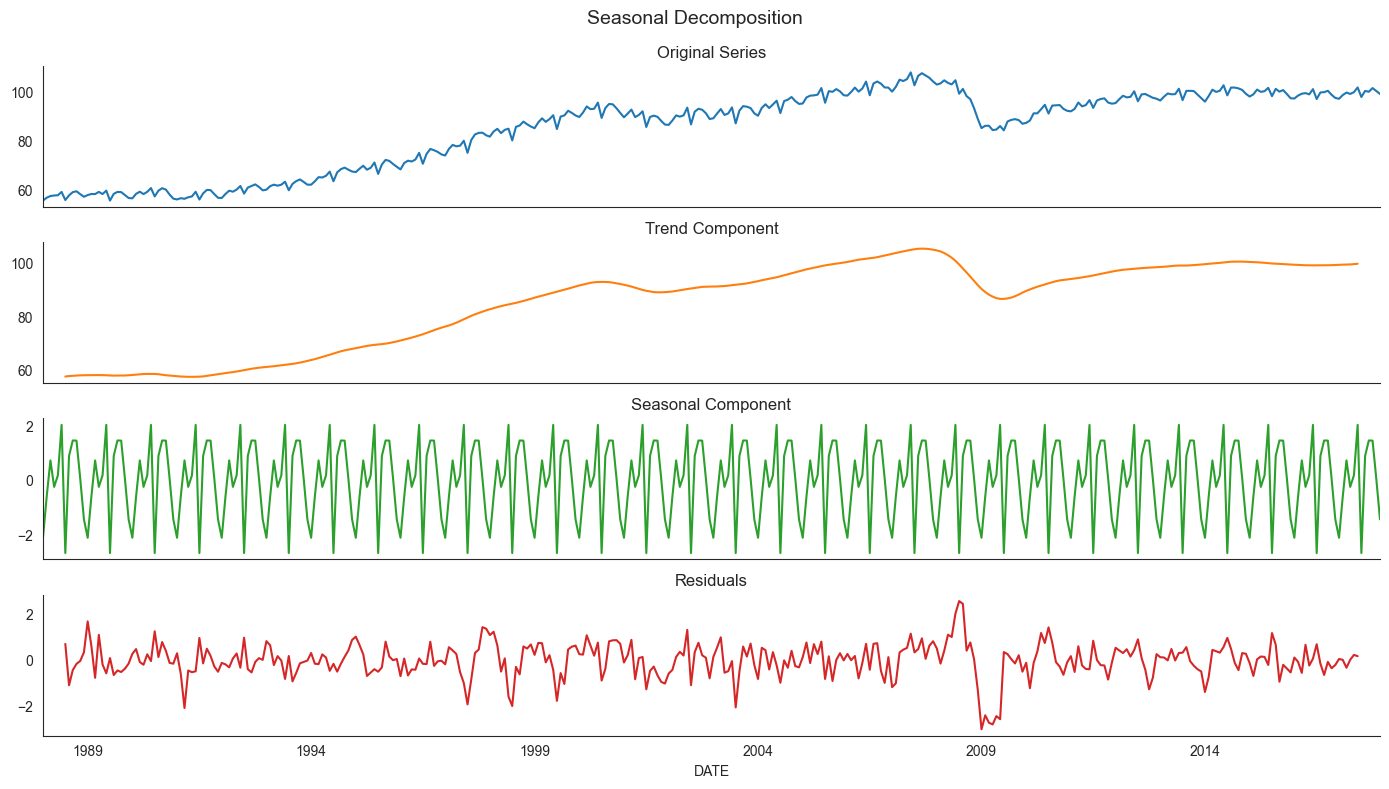

In [6]:
ts = (industrial_production.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

## 시계열 정상성(Time Series Stationarity)

평균, 분산 또는 자기 상관과 같은 정상 시계열의 통계적 특성은 기간과 무관하며, 즉 시간이 지남에 따라 변하지 않습니다. 따라서 **정상성은 시계열에 추세나 계절적 효과가 없고, 평균이나 표준 편차와 같은 기술 통계가 서로 다른 이동 창에 대해 계산될 때 일정하거나 시간이 지남에 따라 크게 변하지 않는다는 것을 의미**합니다. 평균으로 회귀되고 편차의 진폭이 일정하며, 단기적 움직임은 통계적 의미에서 항상 동일하게 보입니다.


보다 공식적으로, 엄격한 정상성은 시계열 관측치의 **모든 하위 집합의 결합 분포가 모든 모멘트에 대해 시간과 무관해야** 합니다. 따라서 평균과 분산 외에도 왜도와 첨도와 같은 더 높은 모멘트도 서로 다른 관측치 간의 지연과 무관하게 일정해야 합니다. 대부분의 응용 분야에서 **정상성을 1차 및 2차 모멘트로 제한하여 시계열이 평균, 분산 및 자기 상관이 일정한 공분산 정상성**이 됩니다.




선형 회귀의 입력 데이터가 결과와 상관관계가 있어야 하는 것처럼 서로 다른 지연에서 관측치 간의 종속성을 특별히 허용한다는 점에 유의하세요. 정상성은 이러한 관계가 안정적임을 의미하며, 이는 모델이 안정적인 통계적 특성 내에서 발생하는 체계적인 패턴을 학습하는 데 집중할 수 있으므로 예측을 용이하게 합니다. 고전적 통계 모델은 시계열 입력 데이터가 정상적이라고 가정하기 때문에 중요합니다.


선형 시계열 모델의 정상성 가정을 충족하려면 종종 여러 단계로 원래 시계열을 변환해야 합니다. 일반적인 변환에는 지수적 성장 패턴을 선형적 추세로 변환하고 분산을 안정화하기 위해 (자연) 로그를 적용하는 것이 포함됩니다. 디플레이션은 추세적 행동을 일으키는 다른 시계열로 시계열을 나누는 것을 의미하며, 예를 들어 명목 시계열을 가격 지수로 나누어 실제 측정값으로 변환하는 것입니다.

> 정상성의 유형



- 엄격 정상성: 시계열의 모든 통계적 특성이 모든 시간 지연에 대해 동일합니다.
- 약한 정상성: 시계열의 평균, 분산, 자기 상관이 시간에 따라 일정합니다.

> 정상성의 중요성


- 정상성은 시계열 모델링에 중요합니다. 대부분의 통계적 시계열 모델은 정상적인 입력 데이터를 가정합니다. 
- 정상성이 없으면 모델이 잘못된 예측을 생성할 수 있습니다.


> 정상성 검정


시계열의 정상성을 검정하는 데 사용할 수 있는 여러 가지 통계 검정이 있습니다. 일반적인 검정에는 다음이 포함됩니다.
- ADF 검정: 단위 근 검정으로 시계열에 단위 근이 있는지 여부를 검정합니다.
- KPSS 검정: 정상성 검정으로 시계열이 정상적인지 여부를 검정합니다.
- 자기 상관 함수(ACF) 및 편자기 상관 함수(PACF) 플롯: 시계열의 자기 상관 구조를 시각화하는 데 사용할 수 있으며 정상성을 평가하는 데 도움이 될 수 있습니다.

> 정상성 변환


시계열이 정상적이지 않은 경우 정상성을 유도하기 위해 데이터를 변환할 수 있습니다. 일반적인 변환에는 다음이 포함됩니다.



- 로그 변환: 지수적 성장 패턴을 선형적 추세로 변환하는 데 사용됩니다.
- 차분: 시계열의 차이를 계산하여 추세를 제거하는 데 사용됩니다.
- 계절 차분: 시계열의 계절적 성분을 제거하는 데 사용됩니다.

### 로그변환

로그 변환 전, 각 값에 0이 없는지 확인

In [7]:
(nasdaq == 0).any(), (industrial_production==0).any()

(False, False)

In [8]:
'로그변환'
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

### 차분(Differencing)

많은 경우 추세 제거만으로는 시계열을 정상적으로 만들기에 충분하지 않습니다. 대신 원래 데이터를 기간 간 및/또는 계절 간 차이 시계열로 변환해야 합니다. 즉, 인접한 데이터 포인트 또는 계절적 지연에서의 값을 서로 뺍니다. 이러한 차분이 로그 변환된 시계열에 적용될 때 결과는 금융적 맥락에서 순간적인 성장률 또는 수익률을 나타낸다는 점에 유의하세요.<br>


단변량 시계열이 d번 차분한 후 정상적이 되면 d차 적분이라고 하며, d=1이면 단순히 적분이라고 합니다. 이러한 행동은 단위 근 때문입니다.<br>


로그 시계열의 차분은 순간적인 수익률을 생성합니다.<br>

In [9]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# 계절적 차분 => 연간 순간적 수익률
'''
계절적 차분은 시계열 데이터에서 계절적 패턴을 제거하는 데 사용되는 차분 유형입니다. 
계절적 차분은 데이터에서 같은 계절(예: 매년 같은 달)의 값을 뺍니다.
계절적 차분이 로그 변환된 시계열에 적용되면 결과는 연간 순간적 수익률을 나타냅니다. 
연간 순간적 수익률은 한 해의 특정 기간과 이전 해의 같은 기간의 로그 가격 차이입니다.

예를 들어, 월간 로그 가격 시계열이 있다고 가정해 보겠습니다. 

계절적 차분을 적용하면 연간 순간적 수익률 시계열이 생성됩니다. 
이 시계열은 각 달의 로그 가격과 이전 해 같은 달의 로그 가격의 차이로 구성됩니다
연간 순간적 수익률은 금융 시장에서 자산의 수익률을 측정하는 데 자주 사용됩니다. 
연간 순간적 수익률은 자산의 성과를 평가하고 투자 결정을 내리는 데 사용할 수 있습니다.
'''

industrial_production_log_diff = industrial_production_log.diff(12).dropna()

### Plot Series

다음 차트는 2017년까지 30년 동안의 NASDAQ 주가 지수와 산업 생산에 대한 시계열을 원래 형태와 로그를 적용한 후 변환된 버전과 그 후에 각각 1차 차분과 계절적 차분(지연 12)을 적용한 버전을 보여줍니다. 이 차트는 또한 ADF p값을 표시하는데, 이를 통해 두 경우 모두 모든 변환 후 단위 근 비정상성 가설을 기각할 수 있습니다.


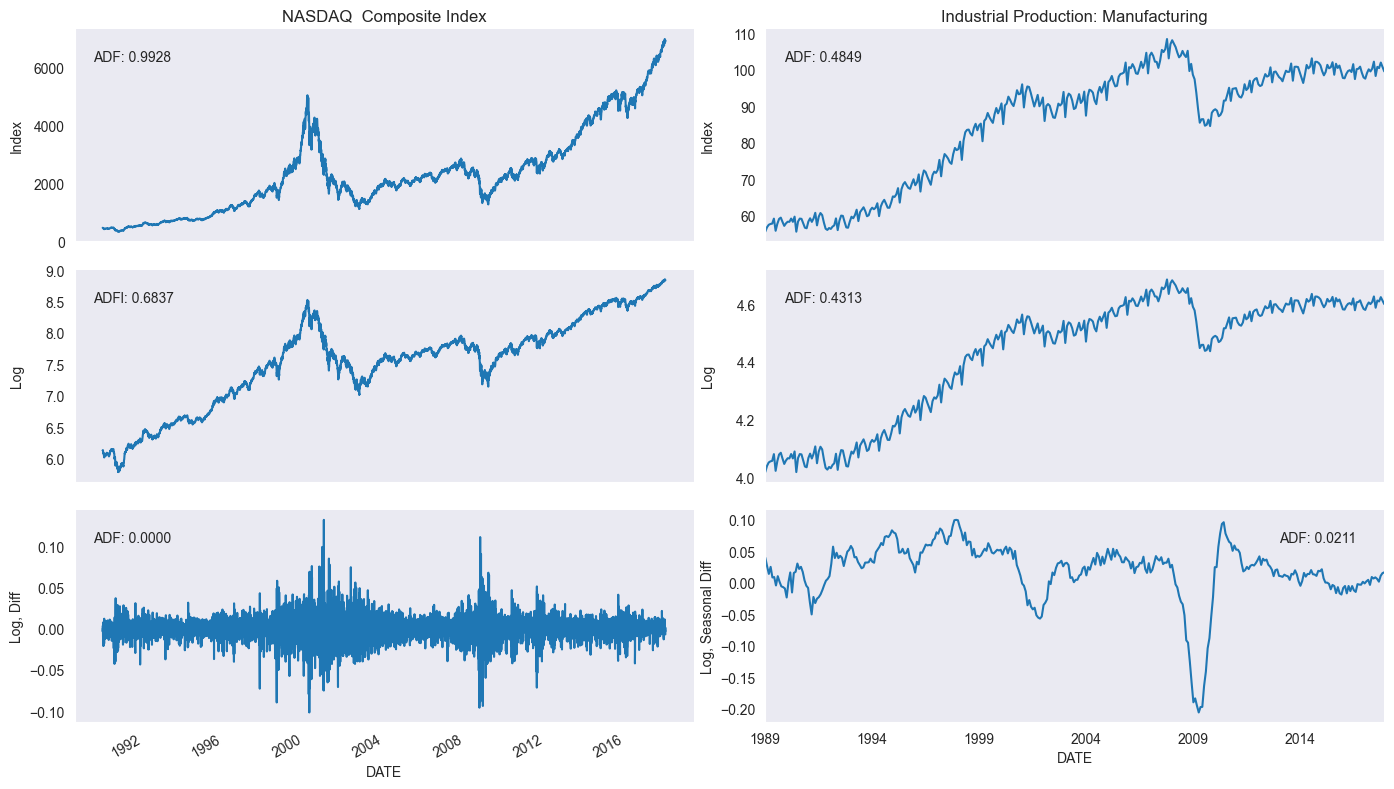

In [10]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

    nasdaq.plot(ax=axes[0][0],
                title='NASDAQ  Composite Index')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}',
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    nasdaq_log.plot(ax=axes[1][0],
                    sharex=True)
    axes[1][0].text(x=.03, y=.85,
                    s=f'ADFl: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}',
                    transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Log')

    nasdaq_log_diff.plot(ax=axes[2][0],
                    sharex=True)
    axes[2][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log, Diff')

    industrial_production.plot(ax=axes[0][1],
                               title='Industrial Production: Manufacturing')
    axes[0][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}',
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    industrial_production_log.plot(ax=axes[1][1],
                    sharex=True)
    axes[1][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}',
                    transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Log')

    industrial_production_log_diff.plot(ax=axes[2][1],
                    sharex=True)
    axes[2][1].text(x=.83, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log, Seasonal Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

- 나스닥 종합 지수: 나스닥 증권 거래소에 상장된 주식들의 시장 지수를 나타내며, 시간에 따라 전반적으로 상승 추세를 보이고 있습니다.
    - ACF (0.6313): 로그를 취한 값의 ACF는 완만해짐
- 산업 생산: 제조업: 제조업의 산업 생산을 나타내며, 점진적인 증가세와 일부 하락 기간이 보입니다.
    - 시계열 반영하여 diff 적용결과 편차가 더욱 커진 것 확인


## 코렐로그램(Correlogram)

자기 상관(시리얼 상관이라고도 함)은 상관 개념을 시계열 맥락에 적용한 것입니다. 상관 계수가 두 변수 간의 선형적 관계의 강도를 측정하는 것처럼, 자기 상관 계수 ρk는 주어진 지연 k로 분리된 시계열 값 간의 선형적 관계의 정도를 측정합니다.


따라서 시계열의 T-1 지연 각각에 대해 하나의 자기 상관 계수를 계산할 수 있습니다. T는 시계열의 길이입니다. 자기 상관 함수(ACF)는 지연의 함수로 상관 계수를 계산합니다. 1보다 큰 지연(즉, 1개 이상의 시간 간격으로 떨어진 관측치 간)에 대한 자기 상관은 이러한 관측치 간의 직접적인 상관과 개입하는 데이터 포인트의 간접적인 영향을 모두 반영합니다. 편자기 상관은 이러한 영향을 제거하고 주어진 지연 거리에서 데이터 포인트 간의 선형적 의존성만 측정합니다. 편자기 상관 함수(PACF)는 더 짧은 지연에서 상관의 영향이 제거된 후 발생하는 모든 상관을 제공합니다.


PACF와 ACF 간의 정확한 이론적 관계를 기반으로 샘플 자기 상관에서 편자기 상관을 추정하는 알고리즘이 있습니다.


코렐로그램은 단순히 순차적 지연 k=0,1,...,n에 대한 ACF 또는 PACF의 플롯입니다. 한눈에 여러 지연에 걸친 상관 구조를 검사할 수 있습니다. 코렐로그램의 주요 용도는 결정적 추세 또는 계절성의 영향을 제거한 후 자기 상관을 감지하는 것입니다. ACF와 PACF는 모두 선형 시계열 모델 설계를 위한 주요 진단 도구이며, 다음 시계열 변환 섹션에서 ACF와 PACF 플롯의 예를 검토합니다.

### NASDAQ (로그, 차분)

Q-Q 플롯을 사용하여 시계열 관측치 분포의 분위수를 정규 분포의 분위수와 비교하고 ACF와 PACF를 기반으로 한 코렐로그램을 사용하여 변환된 시계열의 관련 시계열 특성을 추가로 분석할 수 있습니다.


NASDAQ 플롯의 경우 추세는 없지만 분산은 일정하지 않고 오히려 1980년대 후반, 2001년, 2008년의 시장 혼란기에 군집된 스파이크를 보입니다. Q-Q 플롯은 정규 분포에서 제안하는 것보다 극단값이 더 빈번한 분포의 왜곡된 꼬리를 강조합니다. ACF와 PACF는 여러 지연에서 자기 상관이 유의미하게 나타나는 유사한 패턴을 보입니다.

In [14]:
def plot_correlogram(x, lags=None, title=None):
    """시계열 데이터의 자기 상관과 편자기 상관을 시각화하는 함수

    Args:
        x: 시계열 데이터
        lags: 자기 상관과 편자기 상관을 계산할 지연 수(기본값: 데이터 길이의 1/5 또는 최대 10)
        title: 그래프 제목(선택 사항)
    """

    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='residual')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-stats: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}' 
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nStd: {np.sqrt(var):>16.2f}\nSkewness: {skew:12.2f}\nkurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('지연')
        axes[1][1].set_xlabel('지연')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

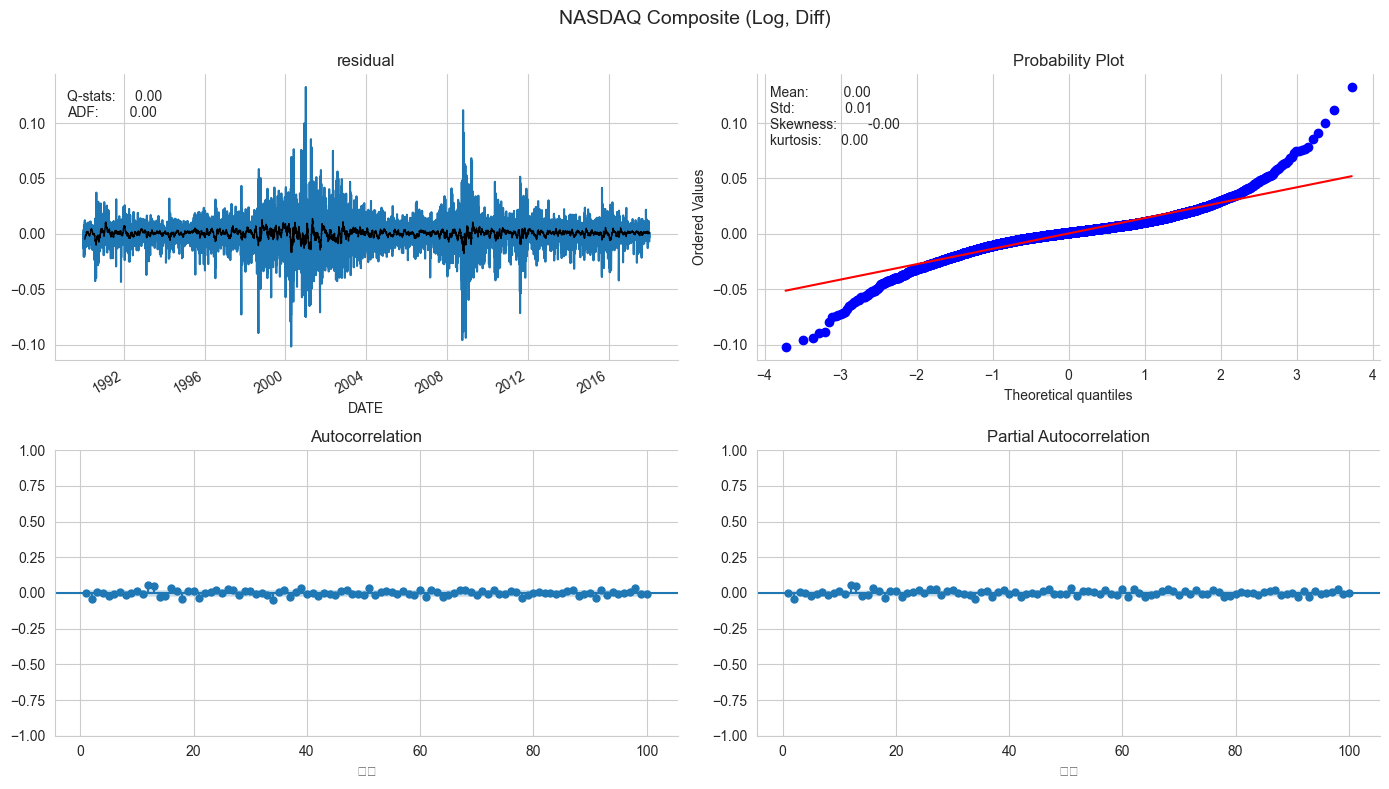

In [15]:
plot_correlogram(nasdaq_log_diff, lags=100, title='NASDAQ Composite (Log, Diff)')

### 산업 생산(로그, 계절적 차분)

산업 제조 생산에 대한 월간 시계열의 경우, 2008년 위기 이후 큰 음의 이상치와 Q-Q 플롯에서 해당 왜도가 나타납니다. 자기 상관은 NASDAQ 수익률보다 훨씬 높고 매끄럽게 감소합니다. PACF는 지연 1과 13에서 뚜렷한 양의 자기 상관 패턴과 지연 3과 4에서 유의미한 음의 계수를 보입니다.

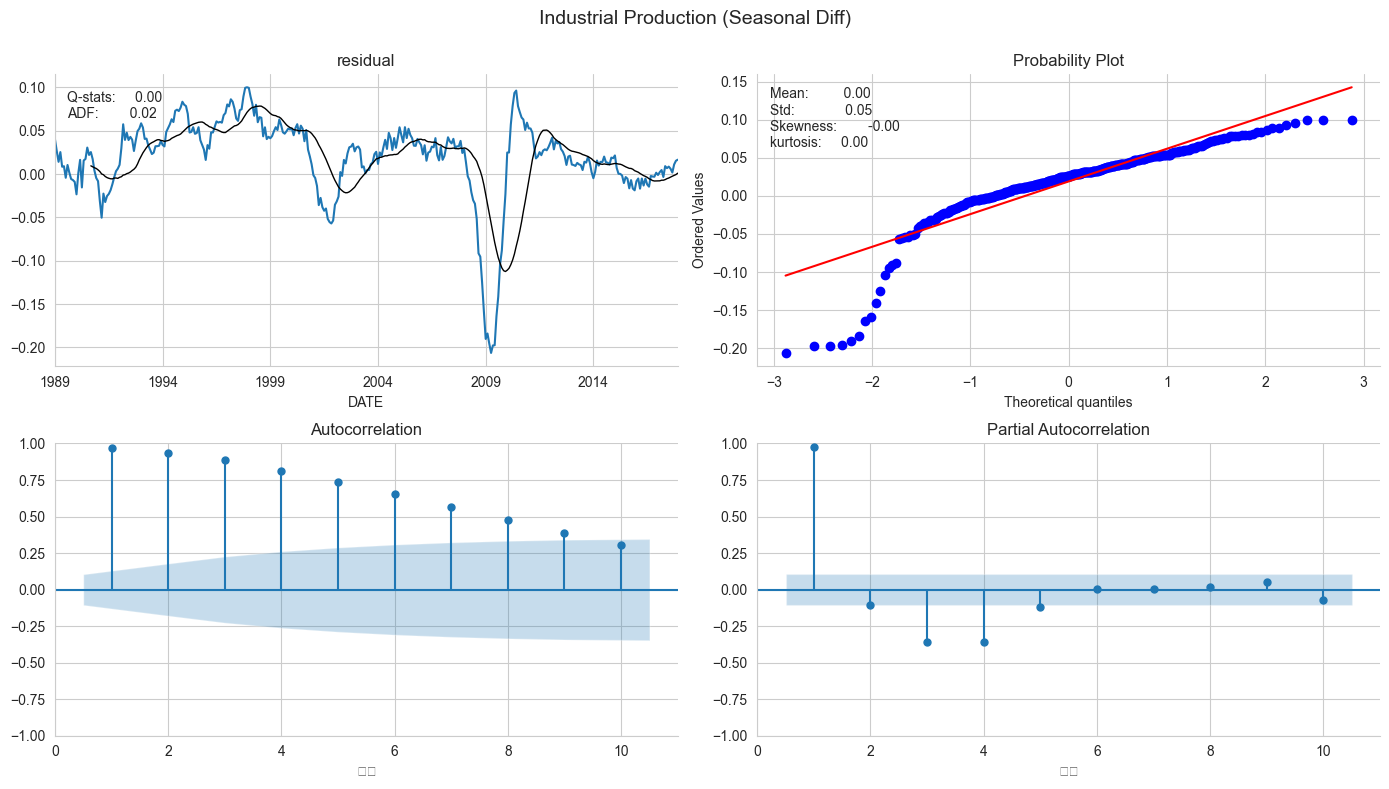

In [16]:
plot_correlogram(industrial_production_log_diff, title='Industrial Production (Seasonal Diff)')

# 단변량 ARIMA 모델

단변량 ARIMA 모델은 시계열 데이터를 모델링하는 데 사용되는 통계적 모델 유형입니다. ARIMA는 다음을 나타냅니다.



AR: 자기 회귀(AutoRegressive)
I: 적분(Integrated)
MA: 이동 평균(Moving Average)

ARIMA 모델은 다음과 같은 형태로 표현됩니다.


ARIMA(p, d, q)

여기서:



p: AR 차수(시계열의 과거 값이 현재 값에 영향을 미치는 지연 수)
d: 적분 차수(시계열을 정상적으로 만들기 위해 필요한 차분 수)
q: MA 차수(시계열의 과거 오류가 현재 오류에 영향을 미치는 지연 수)

단변량 ARIMA 모델은 시계열 데이터의 추세, 계절성, 잔차를 모델링하는 데 사용할 수 있습니다. ARIMA 모델은 시계열 데이터의 예측과 시계열 데이터를 기반으로 한 의사 결정에 사용할 수 있습니다.


단변량 ARIMA 모델을 구축하는 단계는 다음과 같습니다.



시계열 데이터를 분석하여 적절한 ARIMA 모델을 선택합니다.
ARIMA 모델을 시계열 데이터에 맞춥니다.
ARIMA 모델의 적합성을 평가합니다.
ARIMA 모델을 사용하여 시계열 데이터를 예측합니다.

단변량 ARIMA 모델은 시계열 데이터를 모델링하는 데 강력한 도구입니다. 시계열 데이터의 예측과 시계열 데이터를 기반으로 한 의사 결정에 사용할 수 있습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

Load monthly industrial production and daily NASDAQ stock market index:

In [5]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

In [6]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

In [38]:
nasdaq_log_diff = nasdaq_log.diff(1).dropna()

# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

## 단변량 시계열 모델 (Univariate Time Series Models)

### 자기회귀 모델 (AR Model)

- 시계열의 값: 관심 시점에서 지연된 값과 과거 교란항을 선형조합하여 시계열 값을 예측
    - 지연된 값: 과거 시계열 값
    - 과거 교란 항: 과거 잔차
    - 선형 조합: 지연된 값과 과거 교란 항을 가중치로 곱한 다음 더하여 현재 값을 예측합니다.
    
지수 평활 모델이 데이터의 추세와 계절성에 대한 설명을 기반으로 하는 반면, ARIMA 모델은 데이터의 자기 상관을 설명하는 것을 목표로 합니다. ARIMA(p, d, q) 모델은 정상성을 필요로 하고 다음 두 가지 구성 요소를 활용합니다.

- 시계열의 p-지연된 값으로 구성된 자기 회귀(AR) 항
- q-지연된 교란을 포함하는 이동 평균(MA) 항 <br>

8장에서는 ARIMA 구성 요소, 단순 자기 회귀(AR) 및 이동 평균(MA) 모델을 소개하고, 이를 자기 회귀 이동 평균(ARMA) 모델에 결합하여 ARIMA 모델로 시계열 적분을 설명하거나 AR(I)MAX 모델로 외생 변수를 포함하는 방법을 설명합니다.


또한 계절적 AR 및 MA 항을 포함하여 툴박스를 확장하여 SARMAX 모델도 포함하는 방법을 설명합니다.

### ARMA vs ARIMA

차분된 시계열의 ARMA 모델은 차분되지 않은 시계열의 ARIMA 모델과 동일한 결과를 생성합니다.

In [39]:
from statsmodels.tsa.arima.model import ARIMA

model1 = ARIMA(endog=nasdaq_log_diff, order=(2,0,2)).fit()
model2 = ARIMA(endog=nasdaq_log, order=(2,1,2)).fit()

In [40]:
model1.params.to_frame('ARMA').join(model2.params.to_frame('diff'))

ARMA      diff
const   0.000383       NaN
ar.L1  -0.188582 -0.224551
ar.L2  -0.130675 -0.169854
ma.L1   0.187295  0.224049
ma.L2   0.088260  0.128358
sigma2  0.000208  0.000208

### 계절적 차분과 SARIMAX

계절적 차분은 계절적 순서(0,1,0,12)를 사용하는 SARIMAX와 동일한 효과가 있습니다.

In [41]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

In [42]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

SARIMAX      diff
ar.L1   1.768300  1.768300
ar.L2  -0.790607 -0.790607
ma.L1  -0.844845 -0.844845
ma.L2   0.311257  0.311257
sigma2  0.000102  0.000102

## 최적의 ARMA lags 찾기

### 후보 모델 실행

다양한 (p, q) 지연 조합을 반복하고 진단 통계를 수집하여 결과를 비교합니다.

In [47]:
from sklearn.metrics import mean_squared_error
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARIMA(endog=train_set, order=(p,0,q)).fit()
            except:
                convergence_error += 1
                continue
            forecast = model.forecast()[0]
            y_pred.append(forecast)
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [48]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [49]:
with pd.HDFStore('arima.h5') as store:
    store.put('arma', arma_results)

We aim to minimize both RMSE and BIC:

In [50]:
arma_results.nsmallest(5, columns=['RMSE'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
4 0  0.009943 -756.279035 -739.554085          0.0           0.0
  1  0.010133 -755.041527 -735.529085          0.0           0.0
2 3  0.010207 -755.702236 -736.189793          0.0           0.0
  2  0.010259 -755.512366 -738.787415          0.0           0.0
  4  0.010328 -753.541890 -731.241956          0.0           0.0

In [51]:
arma_results.nsmallest(5, columns=['BIC'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
4 0  0.009943 -756.279035 -739.554085          0.0           0.0
2 2  0.010259 -755.512366 -738.787415          0.0           0.0
  3  0.010207 -755.702236 -736.189793          0.0           0.0
4 1  0.010133 -755.041527 -735.529085          0.0           0.0
3 2  0.010572 -754.200184 -734.687742          0.0           0.0

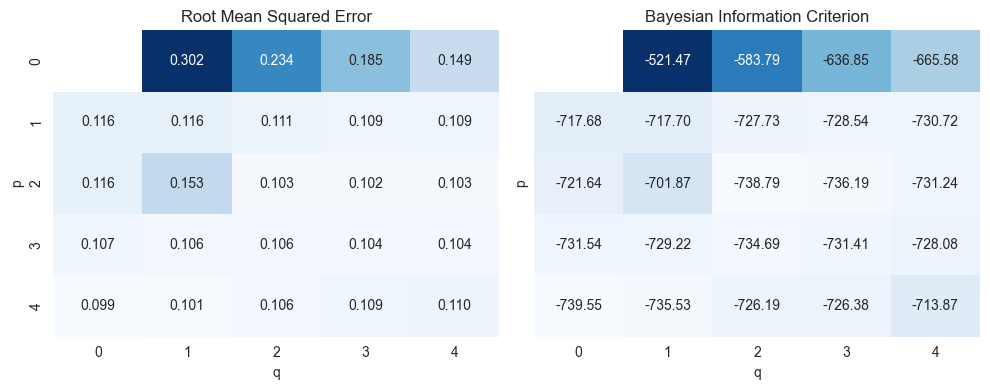

In [52]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [53]:
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
4  0    1.0
2  2    3.0
   3    3.0
4  1    3.0
2  4    6.5
dtype: float64

### Estimating the best ARMA Model

ARMA(4,0) and ARMA(4,1) are close, so we chose the more parsimonious (4,0) configuration:

In [54]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [56]:
best_arma_model = tsa.ARIMA(endog=industrial_production_log_diff, order=(best_p, 0, best_q)).fit()
print(best_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                 ARIMA(4, 0, 0)   Log Likelihood                1104.301
Date:                Thu, 16 May 2024   AIC                          -2196.603
Time:                        05:42:47   BIC                          -2173.489
Sample:                    01-01-1989   HQIC                         -2187.401
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.010      1.879      0.060      -0.001       0.039
ar.L1          0.9329      0.044     21.023      0.000       0.846       1.020
ar.L2          0.3346      0.076      4.388      0.0

### Check Residual Correlogram

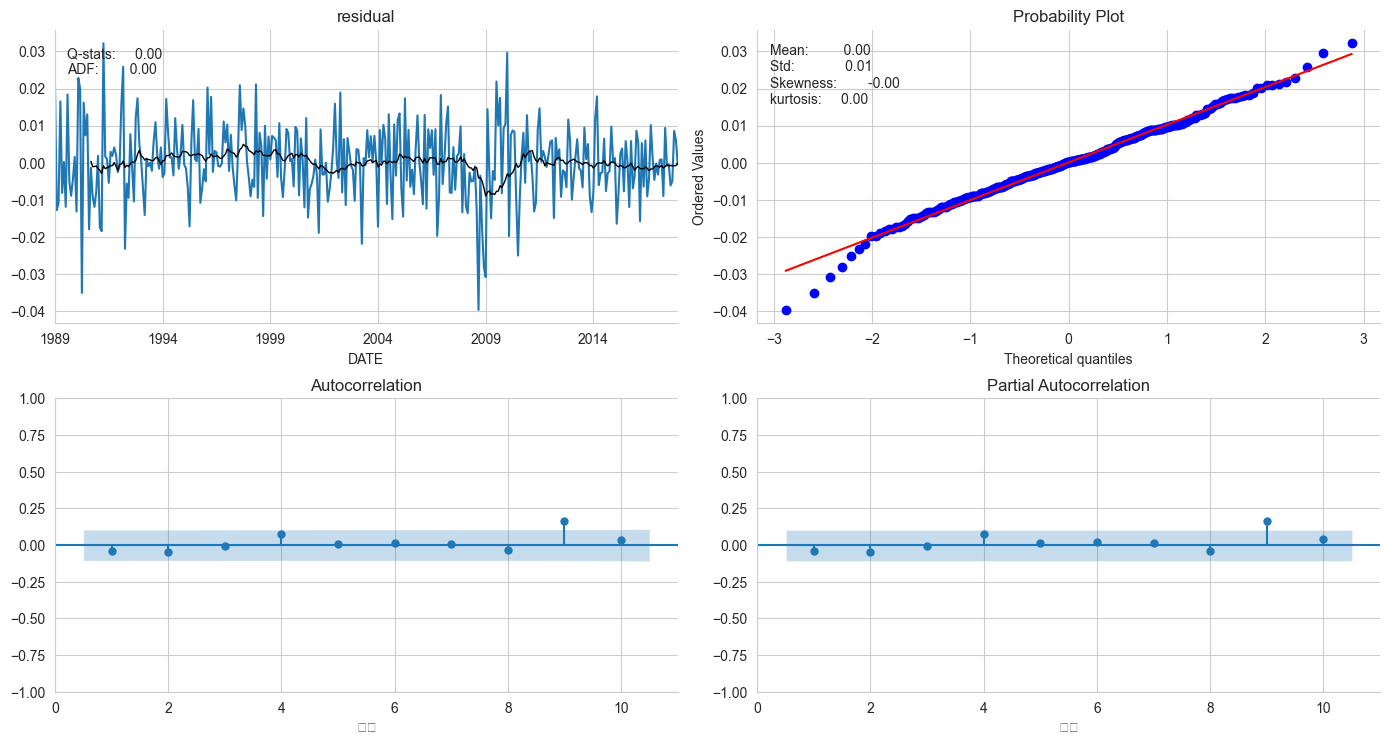

In [57]:
plot_correlogram(best_arma_model.resid)

## SARIMAX

In [58]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [59]:
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1126.632
Date:                              Thu, 16 May 2024   AIC                          -2239.264
Time:                                      05:43:04   BIC                          -2212.299
Sample:                                           0   HQIC                         -2228.529
                                              - 348                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0126      0.437      0.029      0.977      -0.843       0.869
ar.L2          0.98

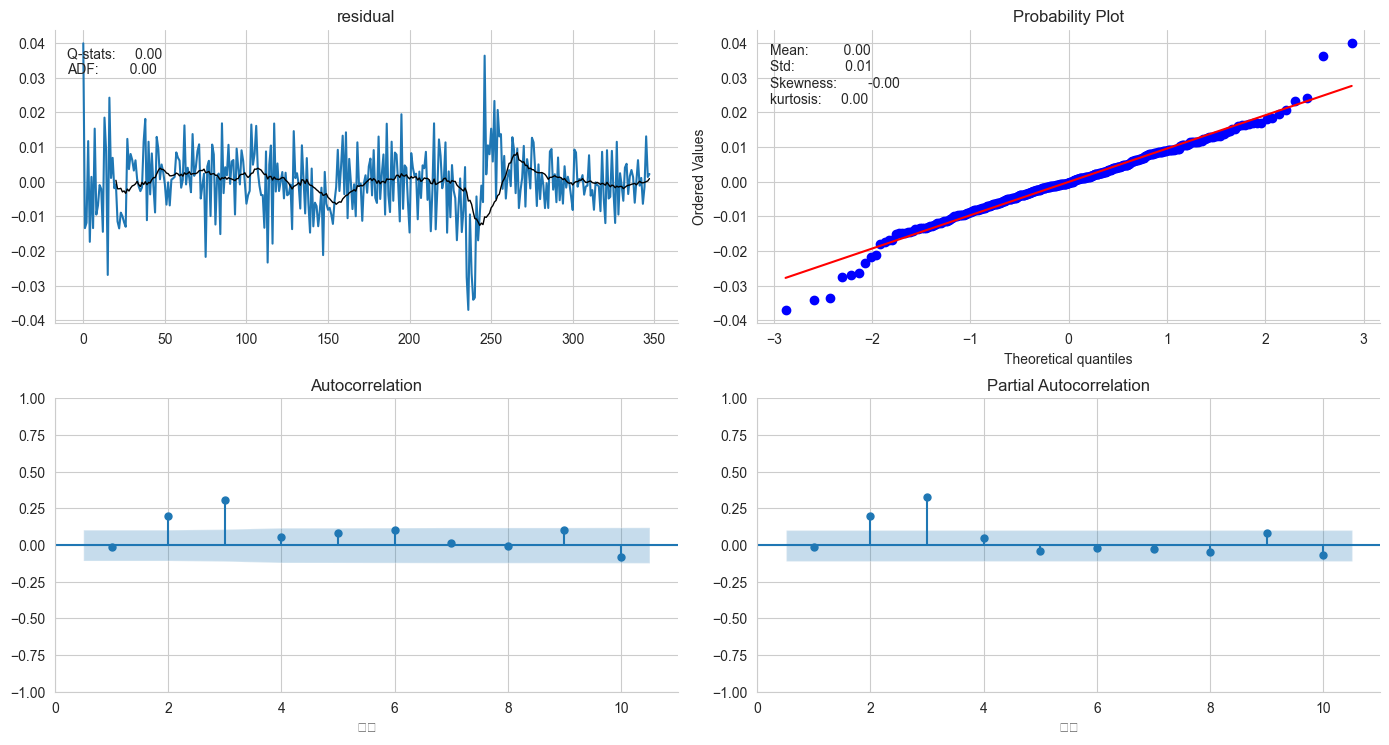

In [60]:
plot_correlogram(pd.Series(sarimax_model.resid))

We will build a SARIMAX model for monthly data on an industrial production time series for the 1988-2017 period. As illustrated in the first section on analytical tools, the data has been log-transformed, and we are using seasonal (lag-12) differences. We estimate the model for a range of both ordinary and conventional AR and MA parameters using a rolling window of 10 years of training data, and evaluate the RMSE of the 1-step-ahead forecast.

### Finding the optimal number of lags

This takes a while...

In [66]:
l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] >  0]
len(params)

81

In [67]:
train_size = 120 # 10 years of training data
results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1, q1, p2, q2 in tqdm(params):
    preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
    aic, bic = [], []
    if p1 == 0 and q1 == 0:
        continue
    convergence_error = stationarity_error = 0
    y_pred = []
    for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
        train_set = industrial_production_log_diff.iloc[T-train_size:T]
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = tsa.SARIMAX(endog=train_set.values,
                                order=(p1, 0, q1),
                                seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
        except LinAlgError:
            convergence_error += 1
        except ValueError:
            stationarity_error += 1

        preds.iloc[i, 1] = model.forecast(steps=1)[0]
        aic.append(model.aic)
        bic.append(model.bic)

    preds.dropna(inplace=True)
    mse = mean_squared_error(preds.y_true, preds.y_pred)
    results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                      preds.y_true.sub(preds.y_pred).pow(2).std(),
                                      np.mean(aic),
                                      np.std(aic),                                                  
                                      np.mean(bic),
                                      np.std(bic),                                                  
                                      convergence_error,
                                      stationarity_error]

100%|███████████████████████████████████████████████████████████████████████████████| 81/81 [2:35:22<00:00, 115.09s/it]


### Compare model metrics

In [68]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 81 entries, (1, 1, 0, 0) to (3, 3, 2, 2)
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          81 non-null     float64
 1   RMSE_std      81 non-null     float64
 2   AIC           81 non-null     float64
 3   AIC_std       81 non-null     float64
 4   BIC           81 non-null     float64
 5   BIC_std       81 non-null     float64
 6   convergence   81 non-null     float64
 7   stationarity  81 non-null     float64
 8   CV            81 non-null     float64
dtypes: float64(9)
memory usage: 6.7 KB


In [69]:
with pd.HDFStore('arima.h5') as store:
    store.put('sarimax', sarimax_results)

In [70]:
with pd.HDFStore('arima.h5') as store:
    sarimax_results = store.get('sarimax')

In [71]:
sarimax_results.nsmallest(5, columns='RMSE')

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
3  2  1  1   0.008901  0.000156 -772.628666  20.837396 -750.328733  20.837396   
      0  2   0.008977  0.000164 -771.734664  23.793885 -749.434730  23.793885   
   3  0  2   0.009007  0.000159 -772.159281  28.276165 -747.071855  28.276165   
      1  2   0.009085  0.000159 -773.842453  26.610987 -745.967536  26.610987   
      2  1   0.009096  0.000148 -769.839168  21.649144 -741.964251  21.649144   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
3  2  1  1           0.0           0.0  0.017509  
      0  2           0.0           0.0  0.018316  
   3  0  2           0.0           0.0  0.017621  
      1  2           0.0           0.0  0.017525  
      2  1           0.0           0.0  0.016286

We also collect the AIC and BIC criteria that show a very high rank correlation coefficient of 0.94, with BIC favoring models with slightly fewer parameters than AIC. The best five models by RMSE are:

In [72]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()

RMSE         AIC         BIC
p1 q1 p2 q2                                  
3  2  1  1   0.008901 -772.628666 -750.328733
      0  2   0.008977 -771.734664 -749.434730
   3  0  2   0.009007 -772.159281 -747.071855
      1  2   0.009085 -773.842453 -745.967536
      2  1   0.009096 -769.839168 -741.964251

In [73]:
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')

RMSE       AIC       BIC
RMSE  1.000000  0.916734  0.779810
AIC   0.916734  1.000000  0.860276
BIC   0.779810  0.860276  1.000000

In [82]:
sarimax_results[['RMSE', 'BIC']]
data

RMSE         BIC
p1 q1 p2 q2                      
1  1  0  0   0.011547 -721.337682
         1   0.009692 -744.054795
         2   0.009519 -741.935387
      1  0   0.010460 -735.518811
         1   0.009759 -743.233664
...               ...         ...
3  3  1  1   0.009115 -746.779015
         2   0.009085 -745.967536
      2  0   0.009382 -740.859930
         1   0.009096 -741.964251
         2   0.009381 -738.544677

[81 rows x 2 columns]

In [86]:
sarimax_results[['RMSE', 'BIC']].rank()

RMSE   BIC
p1 q1 p2 q2            
1  1  0  0   80.0  80.0
         1   45.0  34.0
         2   32.0  49.0
      1  0   75.0  69.0
         1   49.0  40.0
...           ...   ...
3  3  1  1    7.0  22.0
         2    4.0  26.0
      2  0   21.0  50.0
         1    5.0  48.0
         2   20.0  61.0

[81 rows x 2 columns]

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

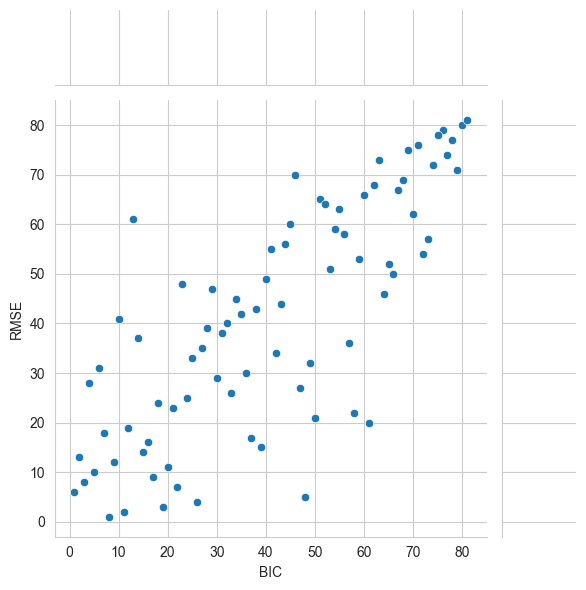

In [87]:
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());

In [88]:
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
3  2  1  1   0.008901  0.000156 -772.628666  20.837396 -750.328733  20.837396   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
3  2  1  1           0.0           0.0  0.017509

### Train best model

In [89]:
p1, q1, p2, q2 = 2, 3, 1, 2

In [90]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()

In [91]:
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  348
Model:             SARIMAX(2, 0, 3)x(1, 0, [1, 2], 12)   Log Likelihood                1154.953
Date:                                 Fri, 17 May 2024   AIC                          -2291.907
Time:                                         21:48:06   BIC                          -2257.237
Sample:                                              0   HQIC                         -2278.104
                                                 - 348                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3350      0.124     10.789      0.000       1.092       1

### Check Residual Correlogram

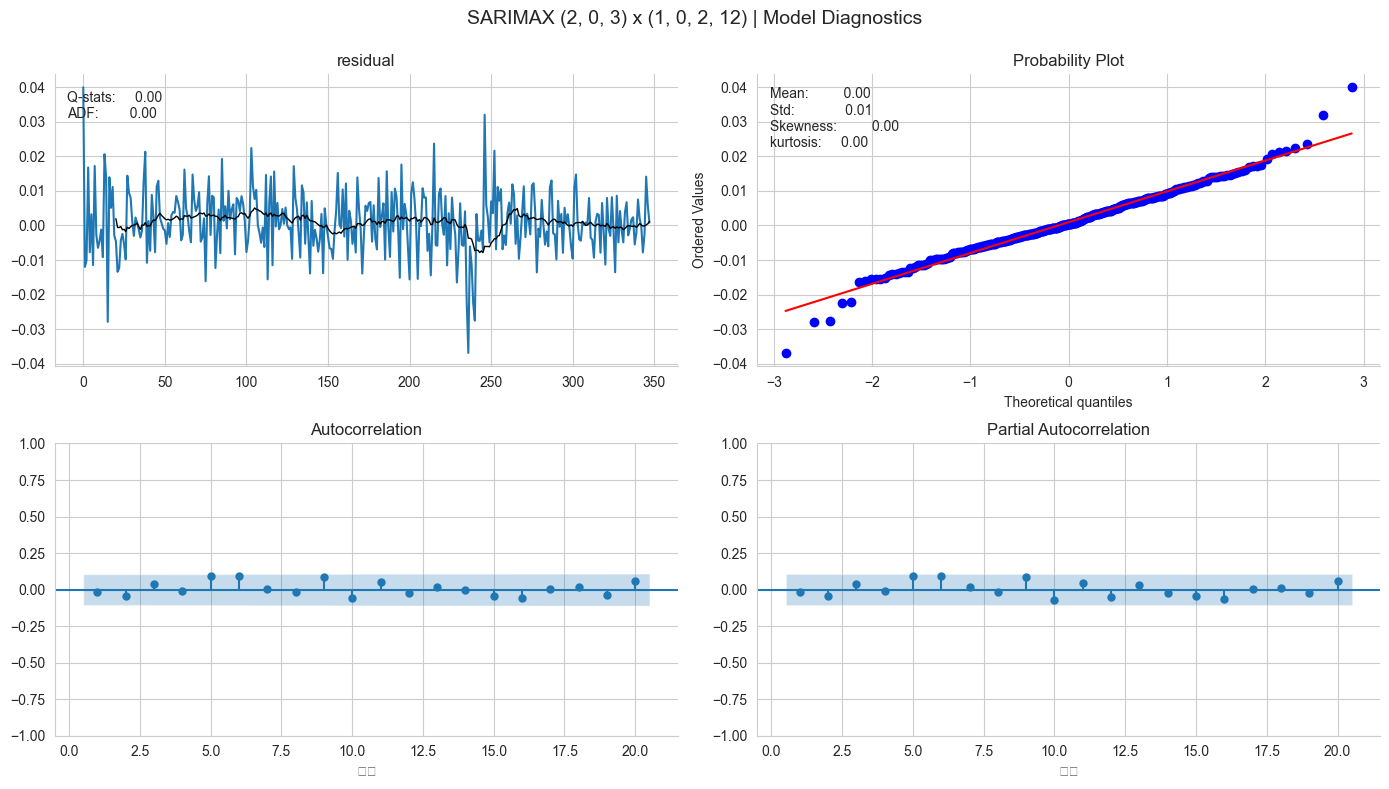

In [92]:
plot_correlogram(pd.Series(best_model.resid),
                 lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')

# ARCH/GARCH 변동성 예측

자산 수익률 시계열에 대한 변동성 모델을 개발하는 것은 다음과 같은 4단계로 구성됩니다.


ACF와 PACF에서 드러난 시계열 의존성을 기반으로 금융 시계열에 대한 ARMA 시계열 모델을 구축합니다.
제곱 잔차 시계열에 대한 ACF와 PACF에 다시 의존하여 모델의 잔차에 대한 ARCH/GARCH 효과를 테스트합니다.
시계열 상관 효과가 유의미한 경우 변동성 모델을 지정하고 평균 및 변동성 방정식을 공동으로 추정합니다.
적합된 모델을 신중하게 확인하고 필요한 경우 개선합니다.
변동성 예측을 수익률 시계열에 적용할 때 시계열 의존성이 제한될 수 있으므로 ARMA 모델 대신 상수 평균을 사용할 수 있습니다.

arch 라이브러리는 변동성 예측 모델을 추정하는 데 여러 옵션을 제공합니다. 상수 평균, 위의 단변량 시계열 모델 섹션에서 논의한 AR(p) 모델, 단기, 중기, 장기 투자자의 거래 빈도를 포착하기 위해 일일(1일), 주간(5일), 월간(22일) 지연을 사용하는 최근의 이기종 자기 회귀 과정(HAR)을 포함하여 예상 평균을 모델링하는 여러 옵션을 제공합니다.


평균 모델은 ARCH와 GARCH 외에도 양수와 음수 수익률 간의 비대칭 효과를 허용하는 지수 GARCH(EGARCH) 모델과 HAR 평균 모델을 보완하는 이기종 ARCH(HARCH) 모델을 포함하는 여러 조건부 이분산성 모델과 공동으로 정의하고 추정할 수 있습니다.

In [93]:
import warnings
warnings.filterwarnings('ignore')

In [105]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller

from sklearn.metrics import mean_squared_error

from scipy.stats import probplot, moment

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
sns.set_style('whitegrid')

In [107]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

GARCH 모델 사용법을 설명하기 위해 1998-2017년의 일별 NASDAQ 수익률을 사용합니다.

In [108]:
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2000', '2020').squeeze()
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100) # rescale to faciliate optimization

## 수익률과 변동성 탐구

재조정된 일별 수익률 시계열은 제한된 자기 상관만을 나타내지만, 평균으로부터의 제곱 편차는 느리게 감소하는 ACF와 처음 두 개에 대해 높고 처음 여섯 개의 지연 후에야 차단되는 PACF에 반영된 상당한 메모리를 갖습니다.

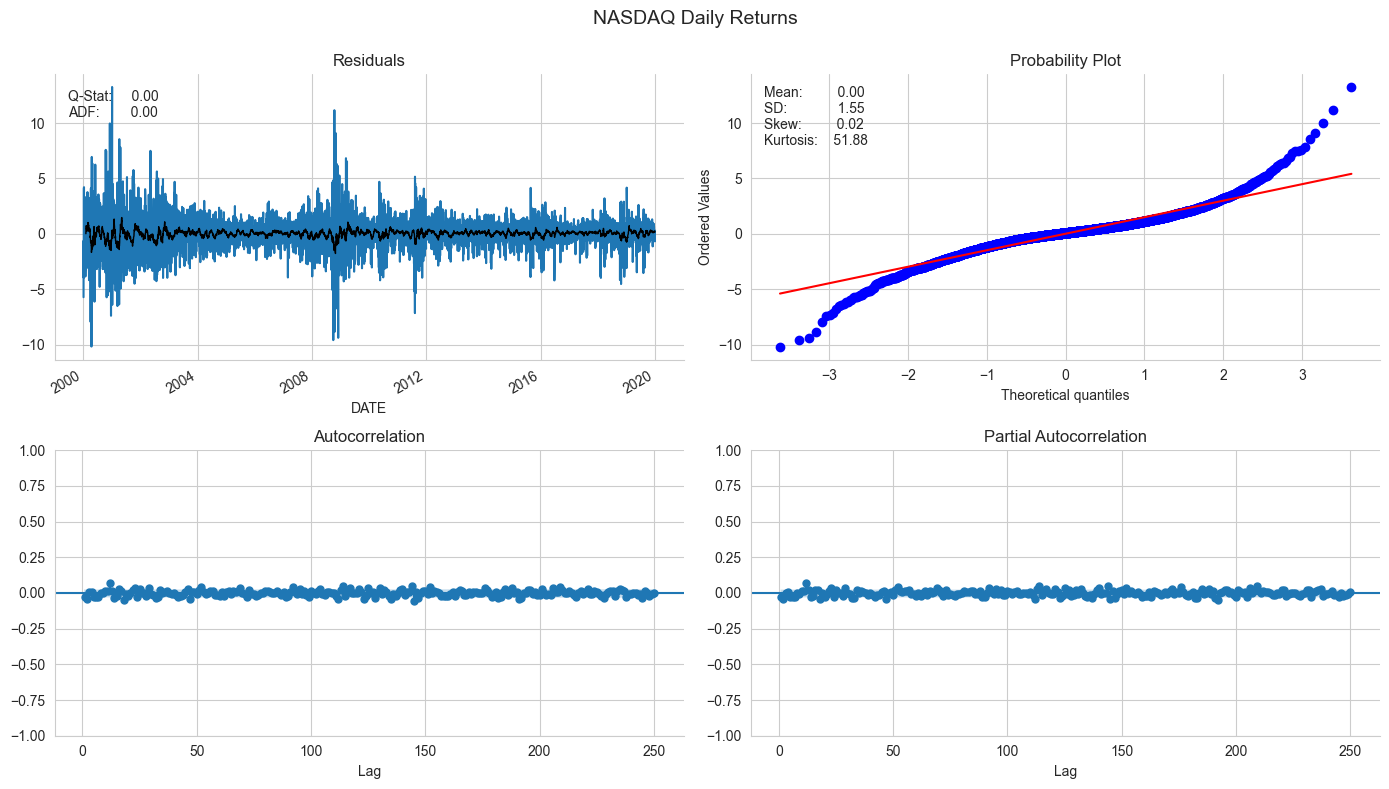

In [109]:
plot_correlogram(nasdaq_returns, lags=250, title='NASDAQ Daily Returns')

The function plot_correlogram produces the following output:

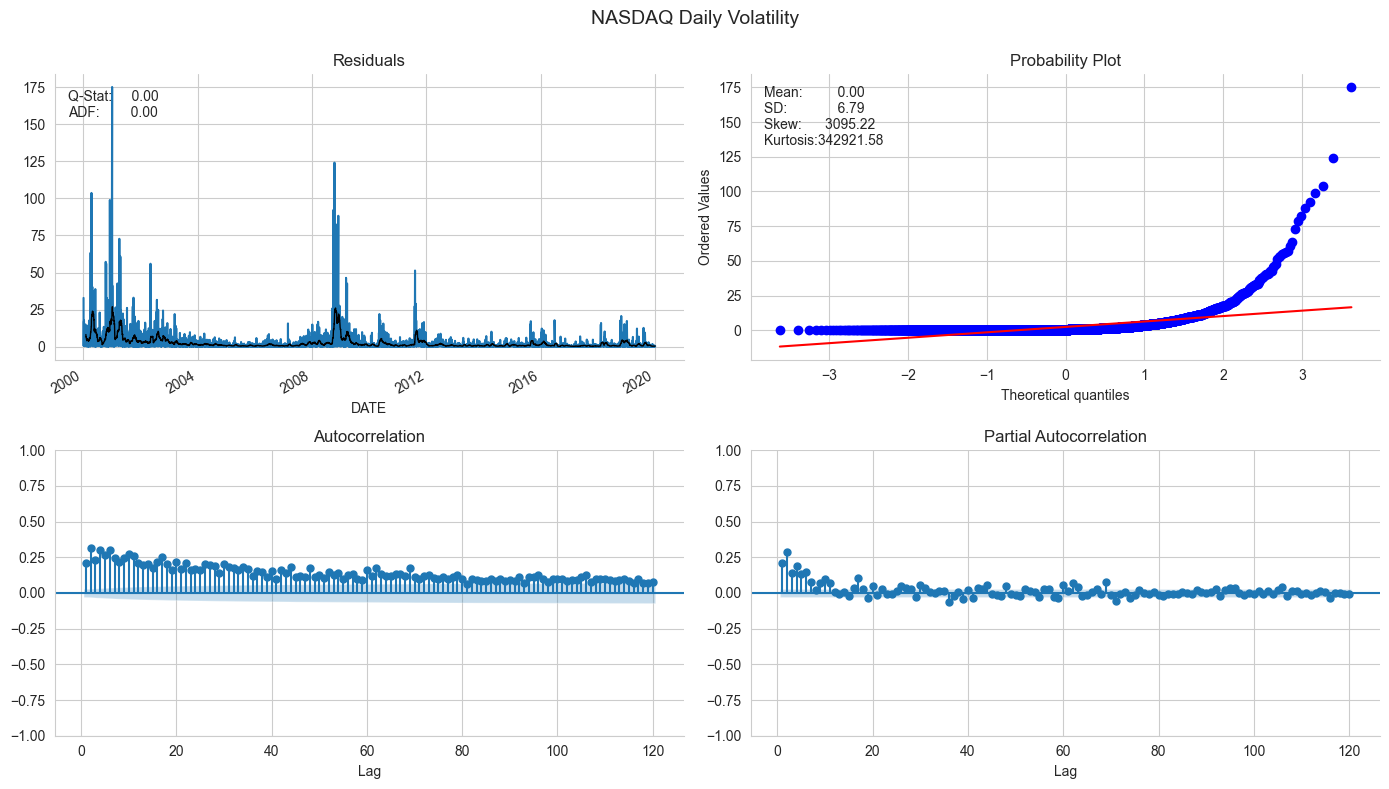

In [110]:
plot_correlogram(nasdaq_returns.sub(nasdaq_returns.mean()).pow(2), lags=120, title='NASDAQ Daily Volatility')

## 모델 선택: Rollng Out of Sample 예측

따라서 과거 변동성의 선형적 관계를 포착하기 위해 GARCH 모델을 추정할 수 있습니다. 1-4 범위의 p와 q를 사용하여 GARCH(p, q) 모델을 추정하기 위해 10년 롤링 윈도우를 사용하여 1단계 아웃-오브-샘플 예측을 생성합니다.


그런 다음 예측된 변동성의 RMSE를 수익률의 평균으로부터의 실제 제곱 편차와 비교하여 가장 예측력 있는 모델을 식별합니다. 변동성의 매우 높은 양의 왜도에 반영된 극단적인 수익률 값의 영향을 제한하기 위해 윈저라이즈된 데이터를 사용하고 있습니다.

In [111]:
trainsize = 10 * 252  # 10 years
data = nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05),
                           upper=nasdaq_returns.quantile(.95))
T = len(nasdaq_returns)
results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [112]:
s = pd.Series(results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)

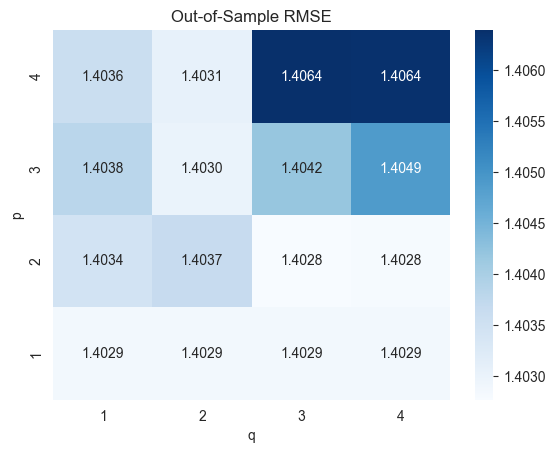

In [113]:
sns.heatmap(s, cmap='Blues', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');

## GARCH(2, 2) 모델 추정

GARCH(2, 2) 모델은 두 번째로 낮은 RMSE를 달성하지만 성능이 약간 더 좋은 GARCH(2, 4)보다 매개변수가 적으므로 이 모델을 추정하여 요약을 검사합니다.


출력에는 극대화된 로그 우도뿐만 아니라 샘플 내 성능을 기반으로 모델을 선택할 때 일반적으로 최소화되는 AIC 및 BIC 기준이 표시됩니다(7장, 선형 모델 참조). 또한 이 경우 상수 추정치에 불과한 평균 모델의 결과와 상수 오메가, AR 매개변수 α, MA 매개변수 β에 대한 GARCH 매개변수를 표시하는데, 이는 모두 통계적으로 유의미합니다.

In [114]:
best_p, best_q = 2, 2,

In [115]:
am = ConstantMean(nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05),
                                      upper=nasdaq_returns.quantile(.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

Iteration:      5,   Func. Count:     47,   Neg. LLF: 7254.927458689642
Iteration:     10,   Func. Count:     86,   Neg. LLF: 7244.082227393178
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7244.081394194959
            Iterations: 13
            Function evaluations: 106
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              NASDAQCOM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7244.08
Distribution:                  Normal   AIC:                           14500.2
Method:            Maximum Likelihood   BIC:                           14539.1
                                        No. Observations:                 4851
Date:                Fri, May 17 2024   Df Residuals:                     4850
Time:         

잔차확인

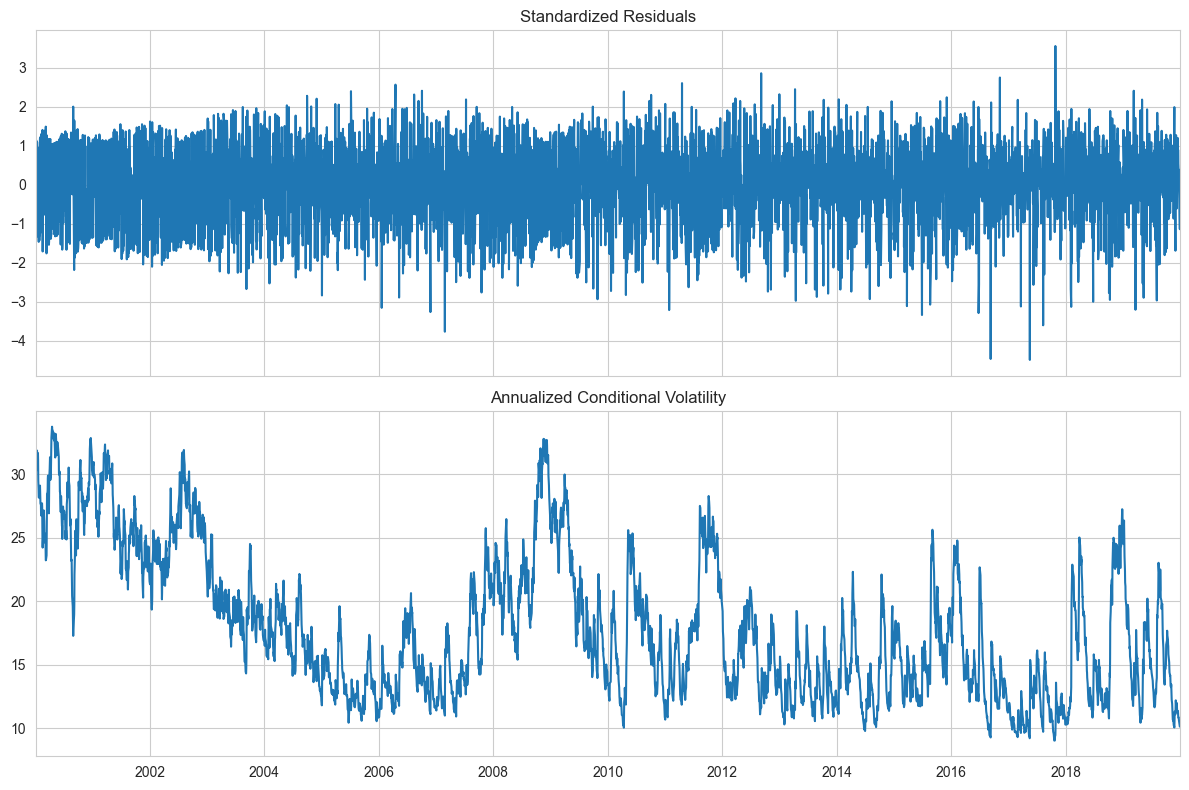

In [116]:
fig = best_model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout();

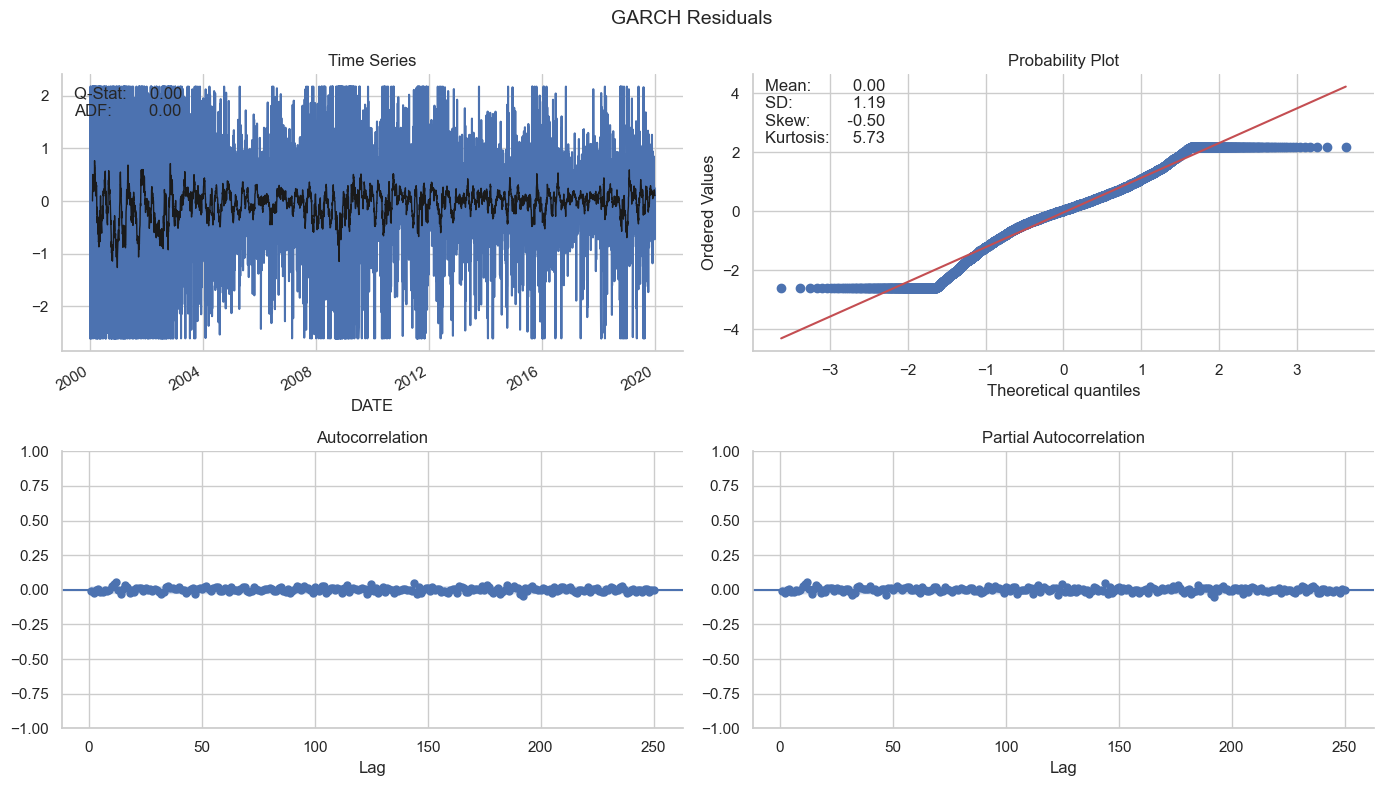

In [138]:
plot_correlogram(best_model.resid.dropna(),
                 lags=250,
                 title='GARCH Residuals')

# 거시 경제 기본 지표 예측에 VAR 모델 사용 방법

벡터 자기 회귀 VAR(p) 모델은 모든 k 시계열의 p 지연된 값을 포함하는 k 방정식 시스템을 생성하여 AR(p) 모델을 k 시계열로 확장합니다. 자체 지연에 대한 계수는 시계열 자체의 동역학에 대한 정보를 제공하는 반면, 교차 변수 계수는 시계열 간의 상호 작용에 대한 통찰력을 제공합니다.

In [117]:
import warnings
warnings.filterwarnings('ignore')

In [118]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

In [119]:
sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

In [120]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [121]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

산업 생산에 대한 단일 시계열 월간 데이터의 단변량 예제를 확장하고 연방준비제도 이사회의 데이터 서비스에서 제공하는 소비자 신뢰 지수에 대한 월간 시계열을 추가합니다. 1970년부터 2017년까지 데이터를 검색하기 위해 익숙한 pandas-datareader 라이브러리를 사용합니다.

In [122]:
sent = 'UMCSENT'
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1970', '2019-12').dropna()
df.columns = ['sentiment', 'ip']

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1972-02-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


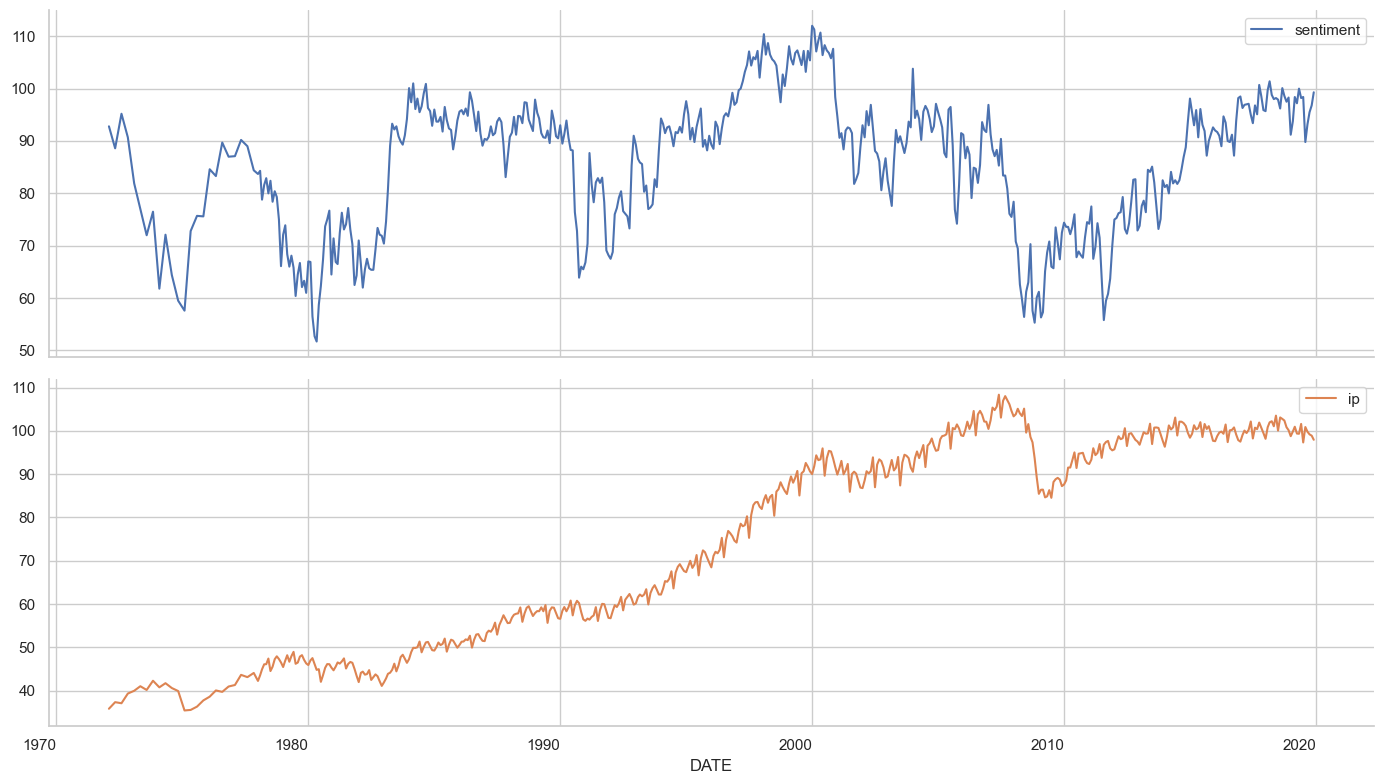

In [124]:
df.plot(subplots=True, figsize=(14,8), rot=0)
sns.despine()
plt.tight_layout();

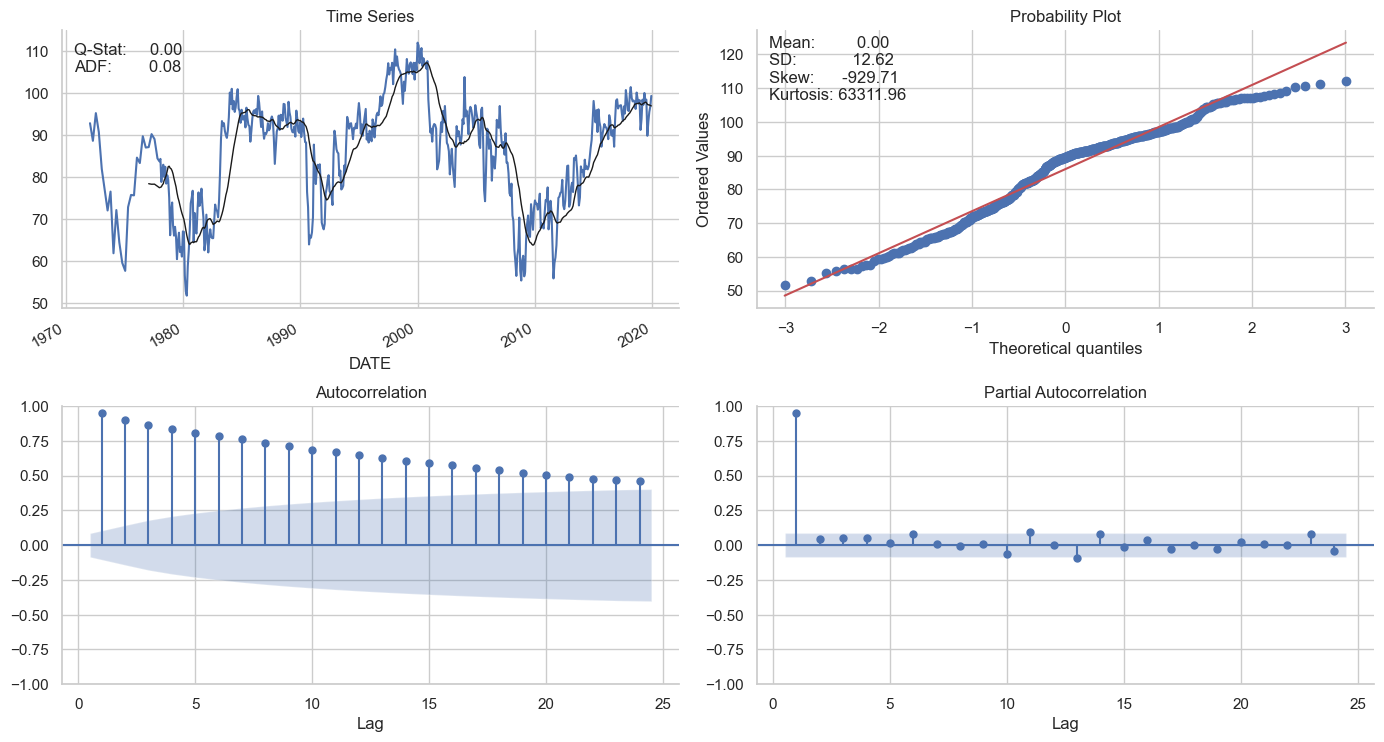

In [125]:
plot_correlogram(df.sentiment, lags=24)

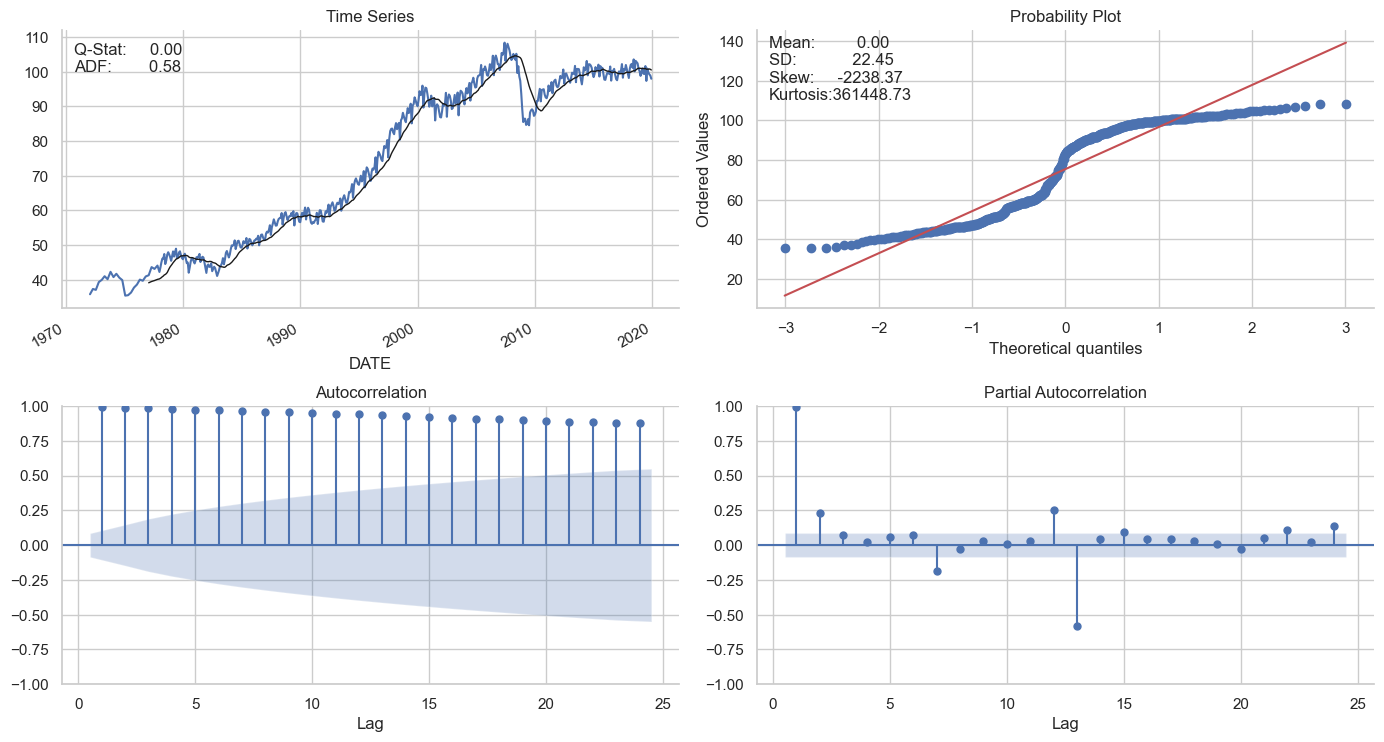

In [126]:
plot_correlogram(df.ip, lags=24)

정상성 변환

산업 생산 시계열을 로그 변환하고 두 시계열 모두의 지연 12를 사용하여 계절적 차분을 수행하면 다음과 같은 정상적인 결과가 생성됩니다.

In [127]:
df_transformed = pd.DataFrame({'ip': np.log(df.ip).diff(12),
                              'sentiment': df.sentiment.diff(12)}).dropna()

코렐로그램 검사

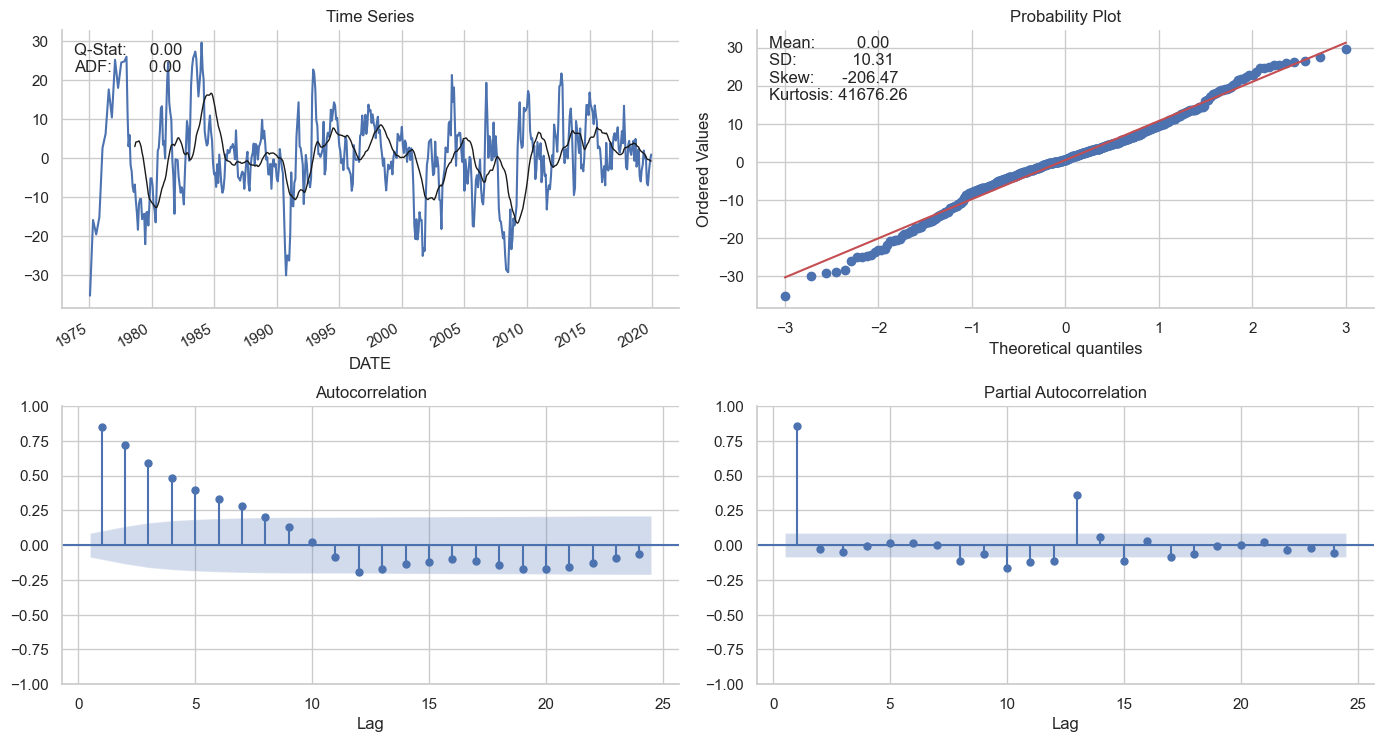

In [128]:
plot_correlogram(df_transformed.sentiment, lags=24)

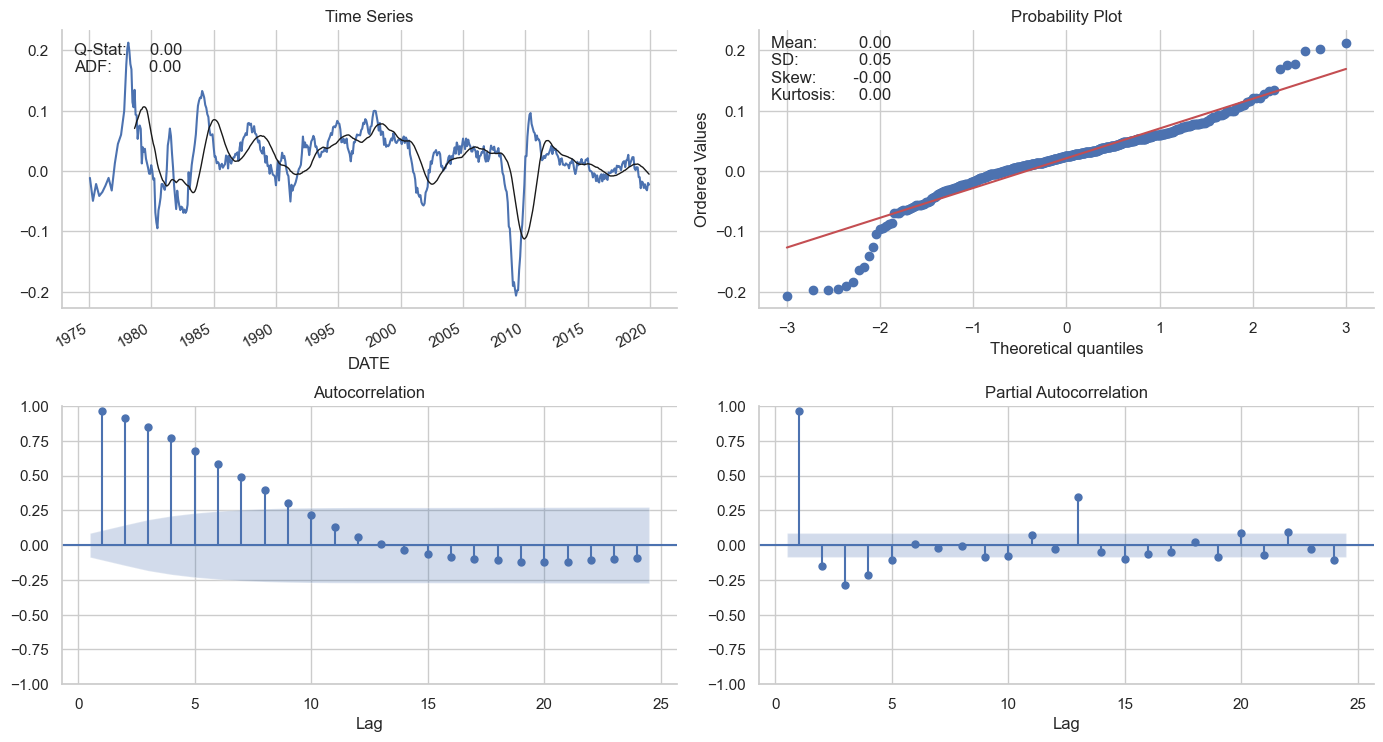

In [129]:
plot_correlogram(df_transformed.ip, lags=24)

In [130]:
test_unit_root(df_transformed)

p-value
ip          0.02%
sentiment   0.00%

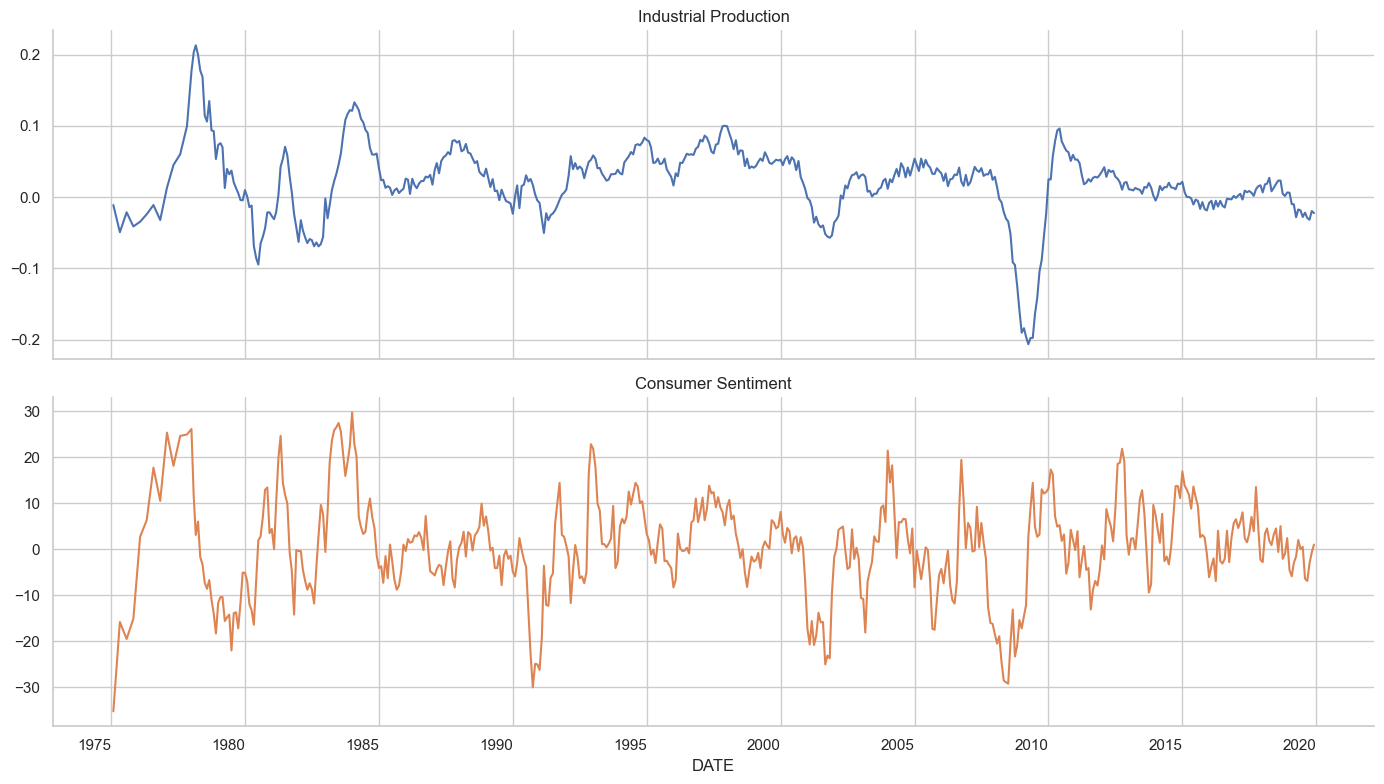

In [131]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Industrial Production', 'Consumer Sentiment'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()

## VAR Model

출력의 크기를 제한하기 위해 2017년까지 상수 추세를 사용하여 statsmodels VARMAX 구현(선택적 외생 변수 허용)을 사용하여 VAR(1) 모델을 추정합니다. 출력에는 두 시계열 방정식에 대한 계수가 포함됩니다.

In [132]:
df_transformed = df_transformed.apply(minmax_scale)

In [133]:
model = VARMAX(df_transformed.loc[:'2017'], order=(1,1), trend='c').fit(maxiter=1000)

In [134]:
print(model.summary())

                            Statespace Model Results                           
Dep. Variable:     ['ip', 'sentiment']   No. Observations:                  492
Model:                      VARMA(1,1)   Log Likelihood                1558.972
                           + intercept   AIC                          -3091.945
Date:                 Fri, 17 May 2024   BIC                          -3037.364
Time:                         22:12:09   HQIC                         -3070.513
Sample:                              0                                         
                                 - 492                                         
Covariance Type:                   opg                                         
Ljung-Box (L1) (Q):             0.20, 0.30   Jarque-Bera (JB):        152.79, 16.56
Prob(Q):                        0.66, 0.58   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.46, 1.03   Skew:                       0.18, 0.20
Prob(H) (two-sided):        

### 진단 Plot

statsmodels는 잔차가 백색 잡음 가정을 충족하는지 확인하는 진단 플롯을 제공하지만, 이 간단한 경우에는 정확히 충족되지 않습니다.

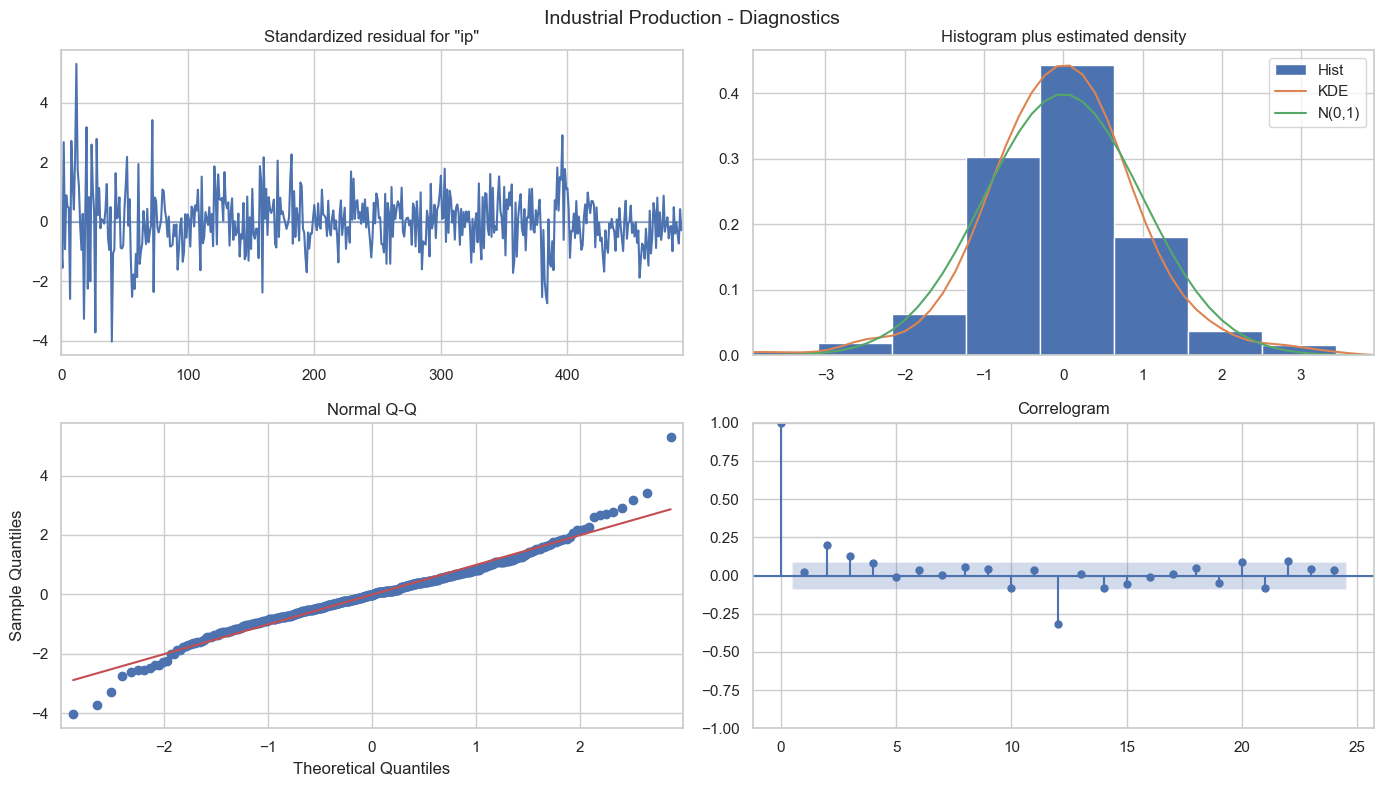

In [144]:
'''
산업 생산
'''
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

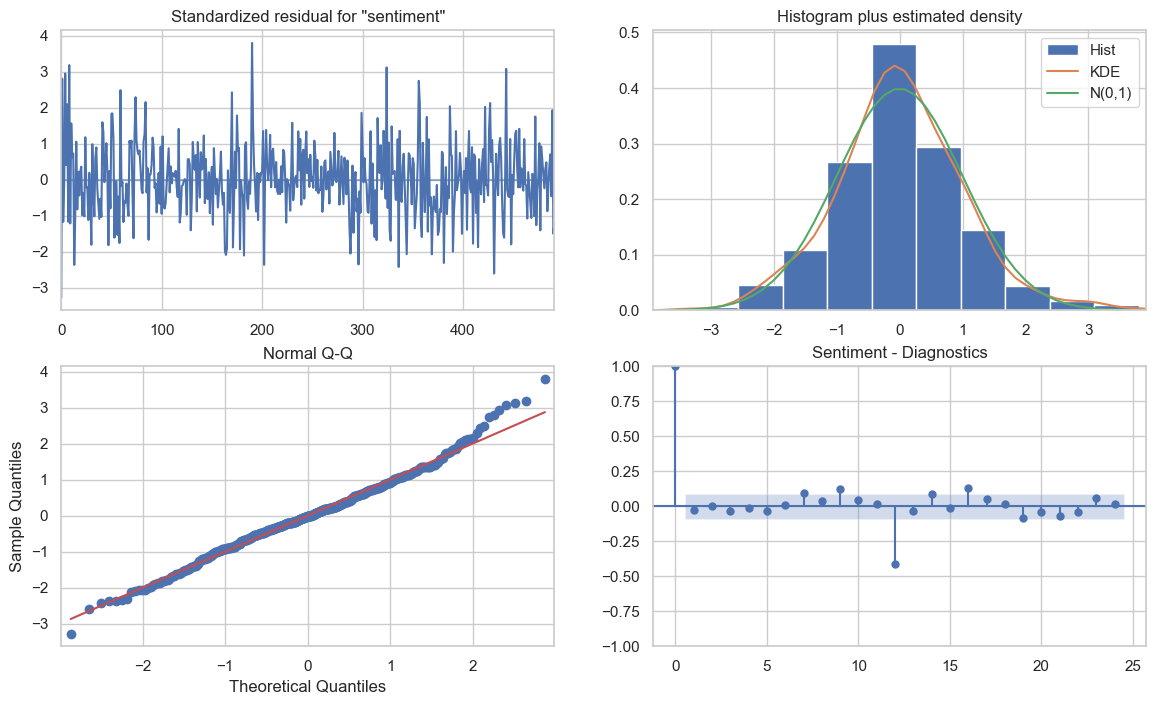

In [145]:
'''
감성
'''

model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.title('Sentiment - Diagnostics');

### 임펄스-응답 함수 (Impulse-Response Function)

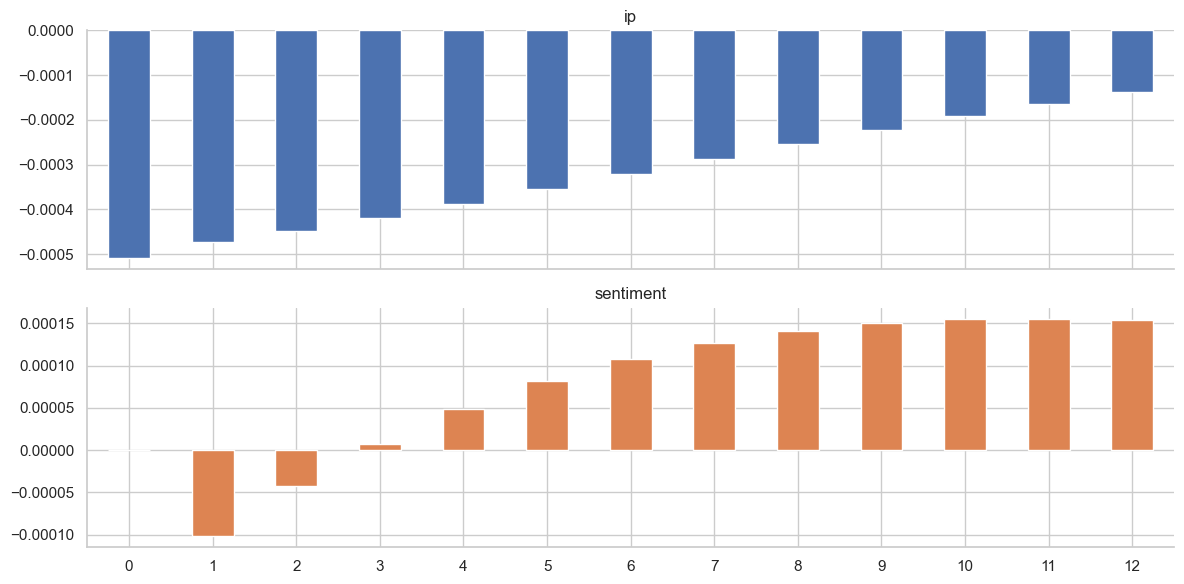

In [146]:
median_change = df_transformed.diff().quantile(.5).tolist()
model.impulse_responses(steps=12,
                        impulse=median_change).plot.bar(subplots=True,
                                                        figsize=(12, 6),
                                                        rot=0,
                                                        legend=False)
sns.despine()
plt.tight_layout()

In [139]:
n =len(df_transformed)
start = n-24

preds = model.predict(start=start+1, end=n)

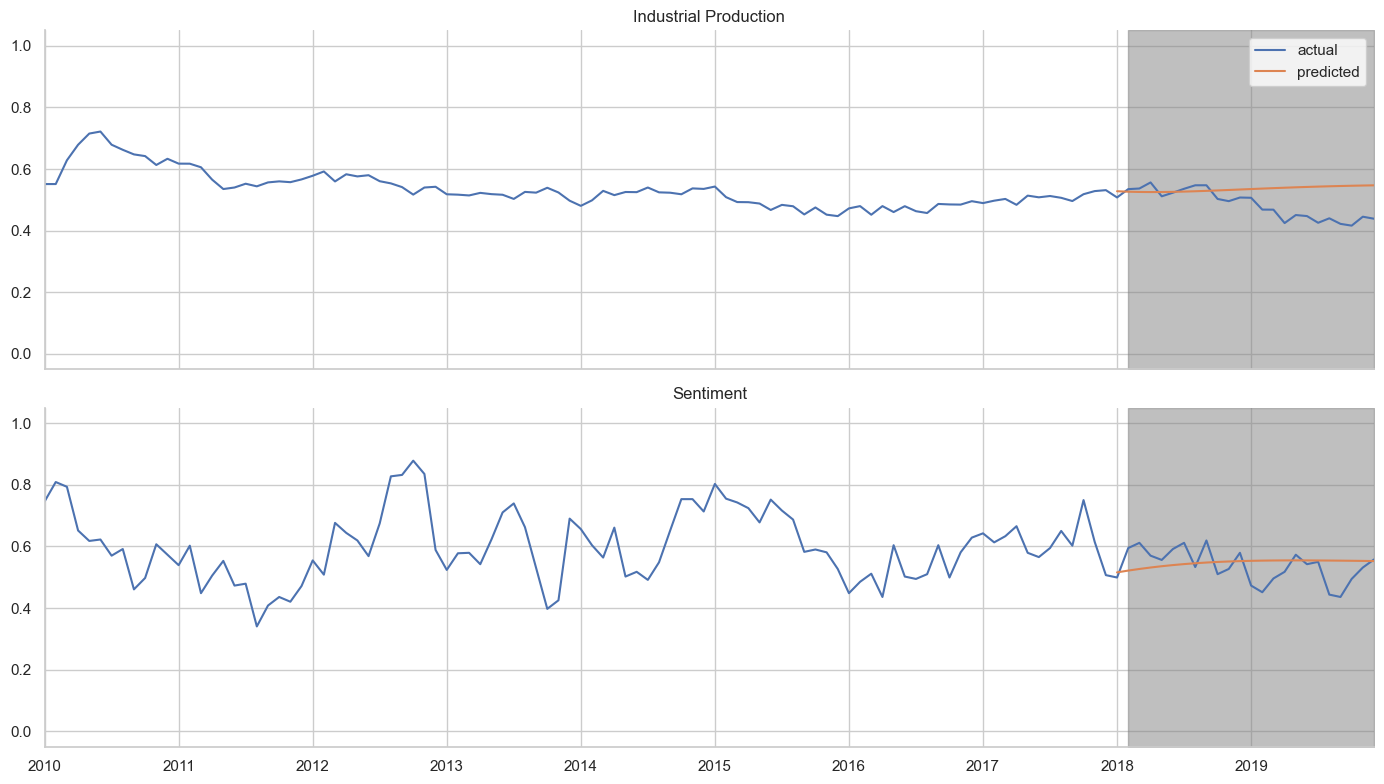

In [140]:
preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed.ip.loc['2010':].plot(ax=axes[0], label='actual', title='Industrial Production')
preds.ip.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.sentiment.loc['2010':].plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

### Out-of-sample 예측

실제 값과 예측 값의 시각화는 예측이 실제 값보다 지연되고 비선형적인 아웃-오브-샘플 패턴을 잘 포착하지 못하는 방식을 보여줍니다.

In [141]:
forecast = model.forecast(steps=24)

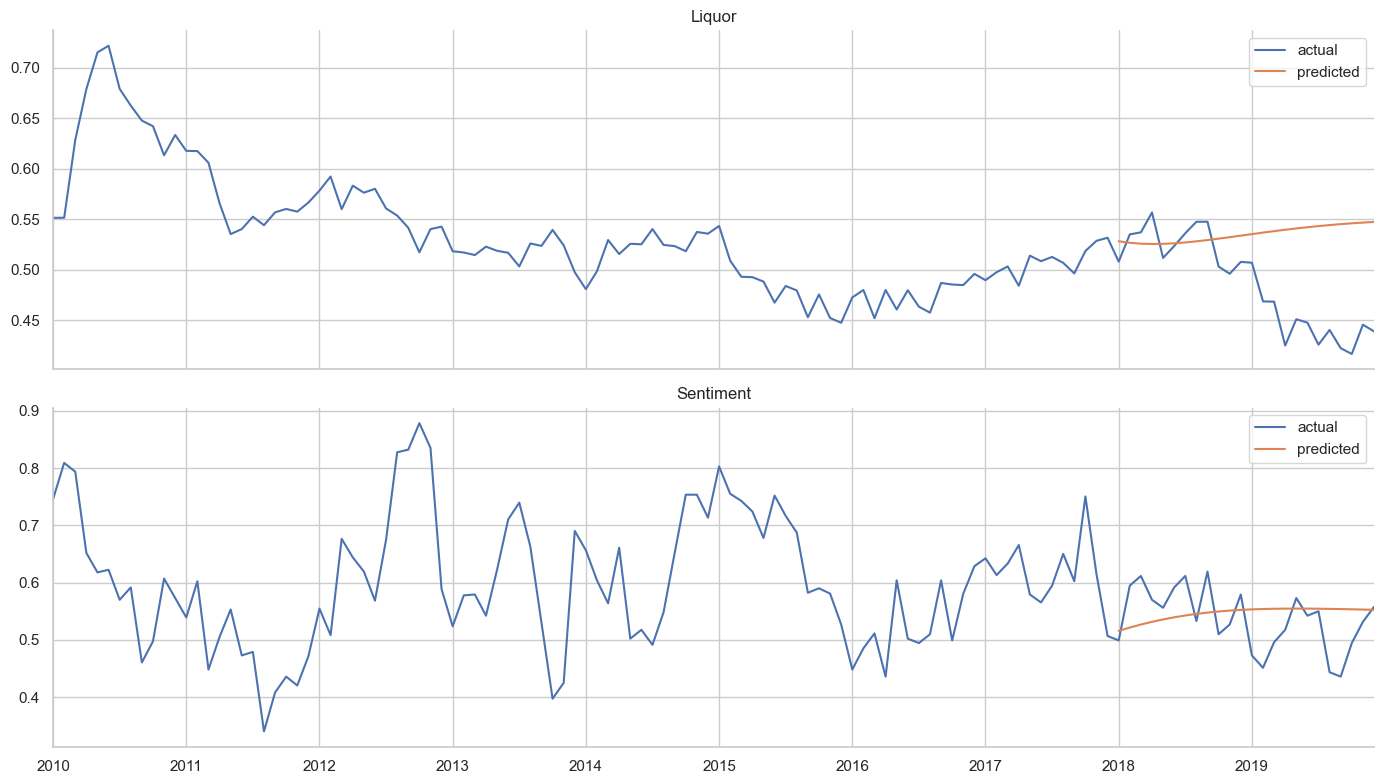

In [142]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed['2010':].ip.plot(ax=axes[0], label='actual', title='Liquor')
preds.ip.plot(label='predicted', ax=axes[0])
axes[0].legend()

df_transformed['2010':].sentiment.plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

In [143]:
mean_absolute_error(forecast, df_transformed.iloc[492:])

0.05271230156645906

# 공적분 검정 및 페어 트레이딩

## 공적분이란?
시계열에 단위 근이 있어 확률적 추세를 생성하고 시계열을 매우 지속적으로 만드는 방법을 살펴보았습니다. 이러한 적분된 시계열을 차분된 형태가 아닌 원래 형태로 선형 회귀 모델의 특징으로 사용하면 결과와의 관계가 종종 통계적으로 유의미하게 나타나는데, 실제로는 그렇지 않습니다. 이러한 현상을 가짜 회귀라고 합니다(자세한 내용은 Wooldridge, 2008의 18장 참조) [Wooldridge, 2008](https://economics.ut.ac.ir/documents/3030266/14100645/Jeffrey_M._Wooldridge_Introductory_Econometrics_A_Modern_Approach__2012.pdf). 따라서 권장되는 해결책은 모델에 사용하기 전에 시계열을 차분하여 정상적으로 만드는 것입니다.


그러나 결과와 하나 이상의 입력 변수 사이에 공적분 관계가 있는 경우에는 예외가 있습니다. 공적분 개념을 이해하려면 먼저 회귀 모델의 잔차가 입력과 출력 시계열의 선형 조합이라는 점을 기억합시다.


일반적으로 하나 이상의 이러한 시계열에 대한 하나의 적분된 시계열의 회귀 잔차는 정상적이지 않은 잔차를 생성하며, 이는 또한 적분되어 랜덤 워크처럼 작동합니다. 그러나 일부 시계열의 경우 이는 해당되지 않습니다. 회귀는 개별 시계열이 그렇지 않더라도 잔차의 형태로 시계열의 선형 조합을 생성하는 계수를 생성합니다. 이러한 시계열은 공적분됩니다.


비기술적인 예는 가죽 끈에 개를 데리고 랜덤 워크를 하는 술 취한 남자입니다. 두 궤적 모두 정상적이지 않지만 개가 가끔 주인에게 돌아오기 때문에 공적분됩니다. 거래 맥락에서 차익 거래 제약은 현물 가격과 선물 가격 간의 공적분을 의미합니다.


즉, 두 개 이상의 공적분 시계열의 선형 조합은 이 선형 조합이 되돌아가는 안정적인 평균을 갖습니다. 이는 개별 시계열이 더 높은 차수로 적분되고 선형 조합이 전체 적분 차수를 줄이는 경우에도 적용됩니다.


공적분은 상관 관계와 다릅니다. 두 시계열은 상관 관계가 높을 수 있지만 공적분될 필요는 없습니다. 예를 들어, 두 개의 성장 시계열이 서로의 상수 배수인 경우 상관 관계는 높지만 선형 조합도 안정적인 평균으로 되돌아가기보다는 증가합니다.

## 페어 트레이딩을 위한 공적분

공적분은 매우 유용합니다. 두 개 이상의 자산 가격 시계열이 공통 평균으로 되돌아가는 경향이 있는 경우, 이는 미래 가격이 반대 방향으로 움직일 것임을 의미하기 때문에 추세로부터의 편차를 활용할 수 있습니다. 공적분의 수학은 더 복잡하므로 실제적인 측면에만 집중하겠습니다. 심층적인 다루기 위해서는 [Lütkepohl (2005)](https://www.springer.com/gp/book/9783540401728).을 참조하세요.


이 노트북에서는 이러한 장기적인 정상적인 관계를 가진 쌍을 식별하고, 불균형이 수정되는 데 필요한 예상 시간을 추정하고, 이러한 도구를 사용하여 롱-숏 페어 트레이딩 전략을 구현하고 백테스트하는 방법을 다룹니다. 공적분을 검정하는 데는 두 가지 방법이 있습니다.



엔글-그레인저 2단계 방법
요한센 검정

책의 장에서는 각 검정에 대해 차례로 논의합니다. 이 노트북에서는 공통 추세로 되돌아가는 공적분 증권을 식별하는 데 어떻게 도움이 되는지 보여줍니다. 이는 통계적 차익 거래 전략에 활용할 수 있는 사실입니다.

In [148]:
import warnings
warnings.filterwarnings('ignore')

In [149]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [319]:
# DATA_PATH = Path('..', 'data')
# STORE = DATA_PATH / 'assets.h5'
STORE = 'd:/drive/SelfStudy/Quant/Source/data/assets.h5'

### 요한센 검정 임계값(Johansen Test Critical Values)

In [320]:

critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [321]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

> Load & Clean Stock & ETF Data

In [322]:
'''
상관관계가 높은 자산 제거
'''

def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)

In [323]:
def check_stationarity(df):
    results = []
    for ticker, prices in df.items():
        results.append([ticker, adfuller(prices, regression='ct')[1]])
    return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

In [ ]:
'''정상성제거'''
def remove_stationary_assets(df, pval=.05):
    test_result = check_stationarity(df)
    stationary = test_result.loc[test_result.adf <= pval, 'ticker'].tolist()
    return df.drop(stationary, axis=1).sort_index()

In [325]:
'''자산선택'''
def select_assets(asset_class='stocks', n=500, start=2010, end=2019):
    idx = pd.IndexSlice
    with pd.HDFStore(STORE) as store:
        df = (pd.concat([store[f'stooq/us/nasdaq/{asset_class}/prices'],
                         store[f'stooq/us/nyse/{asset_class}/prices']])
              # stooq download can have duplicate assets
              .loc[lambda df: ~df.index.duplicated()]
              .sort_index()
              .loc[idx[:, f'{start}':f'{end}'], :]
              .assign(dv=lambda df: df.close.mul(df.volume)))

    # 거래량이 가장 높은 자산 n개 선택
    #단순화를 위해 단축키를 사용합니다. 예를 들어, 연간 이동 평균과 같이 
    #과거 기록에만 기반하여 선택해야 합니다.
    most_traded = (df.groupby(level='ticker')
                   .dv.mean()
                   .nlargest(n=n).index)

    df = (df.loc[idx[most_traded, :], 'close']
          .unstack('ticker')
          .ffill(limit=5)  # 결측치는 5개 값까지 채우기
          .dropna(axis=1))  # 결측값이 있는 자산 제거

    df = remove_correlated_assets(df)
    return remove_stationary_assets(df).sort_index()

We store the intermediate result:

In [326]:
for asset_class, n in [('etfs', 500), ('stocks', 250)]:
    df = select_assets(asset_class=asset_class, n=n)
    df.to_hdf('data.h5', f'{asset_class}/close')

In [327]:
'''
티커딕셔너리 받기
'''

def get_ticker_dict():
    with pd.HDFStore(STORE) as store:
        return (pd.concat([
            store['stooq/us/nyse/stocks/tickers'],
            store['stooq/us/nyse/etfs/tickers'],
            store['stooq/us/nasdaq/etfs/tickers'],
            store['stooq/us/nasdaq/stocks/tickers']
        ]).drop_duplicates().set_index('ticker').squeeze().to_dict())

In [328]:
names = get_ticker_dict()

> 상관 관계 클러스터 시각화 :중간 결과 다시 로드:

Reload intermediate results:

In [329]:
stocks = pd.read_hdf('data.h5', 'stocks/close')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 172 entries, AAPL.US to PCG.US
dtypes: float64(172)
memory usage: 3.3 MB


In [330]:
etfs = pd.read_hdf('data.h5', 'etfs/close')
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 132 entries, SPY.US to EWN.US
dtypes: float64(132)
memory usage: 2.6 MB


In [331]:
tickers = {k: v for k, v in names.items() if k in etfs.columns.union(stocks.columns)}
pd.Series(tickers).to_hdf('data.h5', 'tickers')

In [332]:
corr = pd.DataFrame(index=stocks.columns)
for etf, data in etfs.items():
    corr[etf] = stocks.corrwith(data)

In [333]:
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, AAPL.US to PCG.US
Columns: 132 entries, SPY.US to EWN.US
dtypes: float64(132)
memory usage: 182.8+ KB


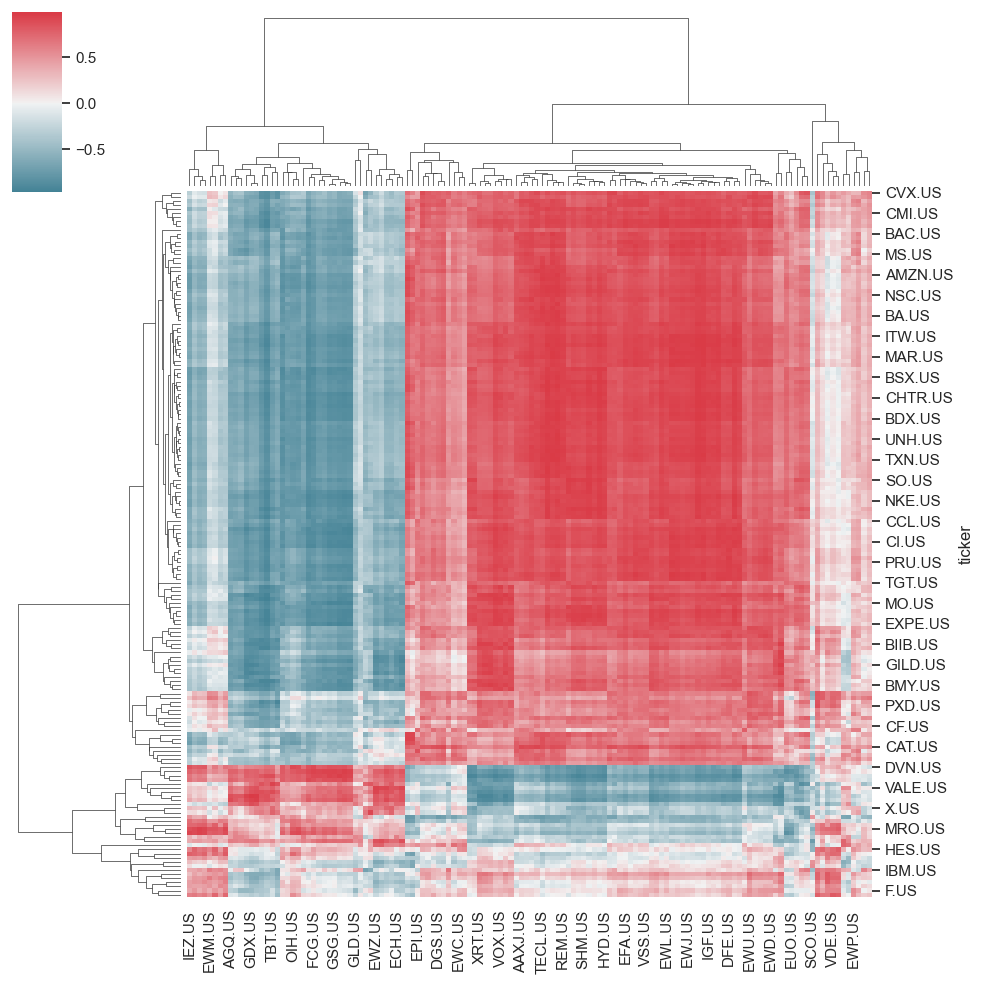

In [334]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.clustermap(corr, cmap=cmap, center=0);

## Candidate Selection using Heuristics

### 계산 복잡도: 실행 시간 비교

이 섹션에서는 다양한 공적분 검정의 실행 시간을 비교합니다. 더 구체적으로, 우리는 단일 자산과 나머지 증권 세트에 대한 검정을 실행하고 있습니다.

In [335]:
stocks.shape, etfs.shape

((2516, 172), (2516, 132))

In [336]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 172 entries, AAPL.US to PCG.US
dtypes: float64(172)
memory usage: 3.3 MB


In [337]:
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 132 entries, SPY.US to EWN.US
dtypes: float64(132)
memory usage: 2.6 MB


In [338]:
security = etfs['AAXJ.US'].loc['2010': '2013']
candidates = stocks.loc['2010': '2013']

In [339]:
security = security.div(security.iloc[0])
candidates = candidates.div(candidates.iloc[0])
spreads = candidates.sub(security, axis=0)

In [340]:
n, m = spreads.shape
X = np.ones(shape=(n, 2))
X[:, 1] = np.arange(1, n+1)

#### Heuristics

In [341]:
%%timeit
np.linalg.inv(X.T @ X) @ X.T @ spreads

356 µs ± 3.35 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [342]:
%%timeit
spreads.std()

352 µs ± 3.69 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [343]:
%%timeit
candidates.corrwith(security)

22.6 ms ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### 공적분 검정

In [344]:
%%timeit
for candidate, prices in candidates.items():
    df = pd.DataFrame({'s1': security,
                       's2': prices})
    var = VAR(df.values)
    lags = var.select_order()
    k_ar_diff = lags.selected_orders['aic']
    coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
    coint(security, prices, trend='c')[:2]
    coint(prices, security, trend='c')[:2]

22.3 s ± 438 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


분명히 공적분 검정은 훨씬 더 비용이 많이 듭니다. 휴리스틱이 똑같이 잘 작동하거나 적어도 '충분히 좋다면' 좋을 것입니다.

### 휴리스틱 계산하기

compute_pair_metrics() 함수는 2010-14년과 2015-19년 동안 23,000개 이상의 주식과 ETF(Exchange Traded Funds)에 대해 다음 거리 지표를 계산합니다.


- 스프레드의 드리프트는 스프레드에 대한 시간적 추세의 선형 회귀로 정의됩니다.
- 스프레드의 변동성
- 정규화된 가격 시계열과 수익률 간의 상관 관계

낮은 드리프트와 변동성, 그리고 높은 상관 관계는 공적분에 대한 간단한 프록시입니다.

이러한 휴리스틱의 예측 능력을 평가하기 위해 statsmodels를 사용하여 이전 쌍에 대한 Engle-Granger 및 Johansen 공적분 검정도 실행합니다. 이는 compute_pair_metrics()의 후반부 루프에서 발생합니다.


우선 Johansen 검정에 지정해야 할 최적의 지연 수를 추정합니다. 두 검정 모두 공적분 시계열(스프레드)이 0이 아닌 절편은 가질 수 있지만 추세는 가질 수 없다고 가정합니다.

In [345]:
def compute_pair_metrics(security, candidates):
    security = security.div(security.iloc[0])
    ticker = security.name
    candidates = candidates.div(candidates.iloc[0])
    spreads = candidates.sub(security, axis=0)
    n, m = spreads.shape
    X = np.ones(shape=(n, 2))
    X[:, 1] = np.arange(1, n + 1)
    
    # compute drift
    drift = ((np.linalg.inv(X.T @ X) @ X.T @ spreads).iloc[1]
             .to_frame('drift'))
    
    # compute volatility
    vol = spreads.std().to_frame('vol')
    
    # return correlation
    corr_ret = (candidates.pct_change()
                .corrwith(security.pct_change())
                .to_frame('corr_ret'))
    
    # normalized price series correlation
    corr = candidates.corrwith(security).to_frame('corr')
    metrics = drift.join(vol).join(corr).join(corr_ret).assign(n=n)
    
    tests = []
    # run cointegration tests
    for candidate, prices in tqdm(candidates.items()):
        df = pd.DataFrame({'s1': security, 's2': prices})
        var = VAR(df.values)
        lags = var.select_order() # select VAR order
        k_ar_diff = lags.selected_orders['aic']
        # Johansen Test with constant Term and estd. lag order
        cj0 = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
        # Engle-Granger Tests
        t1, p1 = coint(security, prices, trend='c')[:2]
        t2, p2 = coint(prices, security, trend='c')[:2]
        tests.append([ticker, candidate, t1, p1, t2, p2, 
                      k_ar_diff, *cj0.lr1])
    columns = ['s1', 's2', 't1', 'p1', 't2', 'p2', 'k_ar_diff', 'trace0', 'trace1']
    tests = pd.DataFrame(tests, columns=columns).set_index('s2')
    return metrics.join(tests)

In [346]:
spreads = []
start = 2010
stop = 2019
etf_candidates = etfs.loc[str(start): str(stop), :]
stock_candidates = stocks.loc[str(start): str(stop), :]
s = time()
for i, (etf_ticker, etf_prices) in enumerate(etf_candidates.items(), 1):
    df = compute_pair_metrics(etf_prices, stock_candidates)
    spreads.append(df.set_index('s1', append=True))
    if i % 10 == 0:
        print(f'\n{i:>3} {time() - s:.1f}\n')
        s = time()

172it [01:02,  2.74it/s]
172it [01:01,  2.81it/s]
172it [01:00,  2.83it/s]
172it [01:00,  2.82it/s]
172it [01:01,  2.78it/s]
172it [01:02,  2.77it/s]
172it [01:00,  2.83it/s]
172it [01:01,  2.81it/s]
172it [01:01,  2.79it/s]
172it [01:01,  2.78it/s]



 10 616.3



172it [01:02,  2.75it/s]
172it [01:02,  2.76it/s]
172it [01:01,  2.81it/s]
172it [01:00,  2.85it/s]
172it [01:00,  2.85it/s]
172it [01:01,  2.79it/s]
172it [01:01,  2.78it/s]
172it [01:00,  2.86it/s]
172it [01:00,  2.87it/s]
172it [01:00,  2.84it/s]



 20 611.7



172it [01:00,  2.83it/s]
172it [01:00,  2.83it/s]
172it [00:59,  2.92it/s]
172it [00:57,  2.98it/s]
172it [00:58,  2.92it/s]
172it [00:59,  2.91it/s]
172it [00:58,  2.96it/s]
172it [00:58,  2.92it/s]
172it [01:01,  2.82it/s]
172it [00:59,  2.88it/s]



 30 595.0



172it [00:59,  2.90it/s]
172it [00:59,  2.89it/s]
172it [00:58,  2.94it/s]
172it [00:59,  2.89it/s]
172it [01:02,  2.77it/s]
172it [00:59,  2.90it/s]
172it [00:59,  2.87it/s]
172it [01:01,  2.81it/s]
172it [01:00,  2.85it/s]
172it [01:00,  2.86it/s]



 40 600.9



172it [01:03,  2.70it/s]
172it [01:01,  2.79it/s]
172it [00:59,  2.87it/s]
172it [01:02,  2.74it/s]
172it [01:02,  2.75it/s]
172it [00:59,  2.87it/s]
172it [00:58,  2.93it/s]
172it [00:59,  2.88it/s]
172it [00:59,  2.89it/s]
172it [01:00,  2.86it/s]



 50 609.3



172it [01:00,  2.86it/s]
172it [00:59,  2.90it/s]
172it [00:59,  2.87it/s]
172it [01:00,  2.86it/s]
172it [00:58,  2.96it/s]
172it [00:58,  2.97it/s]
172it [00:59,  2.90it/s]
172it [00:58,  2.93it/s]
172it [00:58,  2.93it/s]
172it [00:59,  2.89it/s]



 60 592.8



172it [00:58,  2.96it/s]
172it [00:58,  2.94it/s]
172it [00:58,  2.93it/s]
172it [00:58,  2.94it/s]
172it [00:58,  2.94it/s]
172it [00:57,  2.97it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.93it/s]
172it [00:58,  2.93it/s]
172it [00:57,  2.98it/s]



 70 584.6



172it [00:58,  2.94it/s]
172it [00:58,  2.94it/s]
172it [00:57,  2.97it/s]
172it [00:57,  2.97it/s]
172it [00:58,  2.93it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.95it/s]
172it [00:57,  2.98it/s]
172it [00:58,  2.94it/s]
172it [00:58,  2.94it/s]



 80 583.5



172it [00:58,  2.96it/s]
172it [00:58,  2.94it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.94it/s]
172it [00:59,  2.91it/s]
172it [00:57,  2.97it/s]
172it [00:58,  2.94it/s]
172it [00:58,  2.94it/s]
172it [00:57,  2.97it/s]
172it [00:58,  2.96it/s]



 90 584.3



172it [00:57,  2.98it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.96it/s]
172it [00:57,  2.97it/s]
172it [00:58,  2.96it/s]
172it [00:58,  2.94it/s]
172it [00:58,  2.95it/s]
172it [00:57,  2.97it/s]
172it [00:58,  2.96it/s]
172it [00:58,  2.94it/s]



100 582.2



172it [00:58,  2.95it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.96it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.94it/s]
172it [00:57,  2.97it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.94it/s]



110 583.8



172it [00:58,  2.93it/s]
172it [00:58,  2.94it/s]
172it [00:58,  2.95it/s]
172it [00:57,  2.98it/s]
172it [00:57,  2.97it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.96it/s]
172it [00:58,  2.96it/s]
172it [00:58,  2.96it/s]
172it [00:58,  2.96it/s]



120 582.8



172it [00:57,  2.97it/s]
172it [00:58,  2.97it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.95it/s]
172it [00:58,  2.96it/s]
172it [00:58,  2.96it/s]
172it [00:57,  2.97it/s]
172it [00:58,  2.94it/s]
172it [00:58,  2.95it/s]
172it [00:57,  2.97it/s]



130 582.2



172it [00:59,  2.90it/s]
172it [00:58,  2.96it/s]


In [347]:
names = get_ticker_dict()
spreads = pd.concat(spreads)
spreads.index.names = ['s2', 's1']
spreads = spreads.swaplevel()
spreads['name1'] = spreads.index.get_level_values('s1').map(names)
spreads['name2'] = spreads.index.get_level_values('s2').map(names)

In [348]:
spreads['t'] = spreads[['t1', 't2']].min(axis=1)
spreads['p'] = spreads[['p1', 'p2']].min(axis=1)

### Engle-Granger 대 Johansen: 결과를 어떻게 비교할까?

공적분 검정의 유의성을 확인하기 위해 랭크 0과 1에 대한 Johansen 추적 통계량을 각각의 임계값과 비교하고 Engle-Granger p값을 얻습니다.


우리는 Gonzalo와 Lee(1998)의 권장 사항에 따라 두 검정을 모두 적용하고 동의하는 쌍을 수락합니다. 저자들은 의견이 일치하지 않는 경우 추가적인 실사를 제안하는데, 우리는 이를 건너뛸 것입니다.

In [349]:
spreads['trace_sig'] = ((spreads.trace0 > trace0_cv) &
                        (spreads.trace1 > trace1_cv)).astype(int)
spreads['eg_sig'] = (spreads.p < .05).astype(int)

두 샘플 기간에 걸친 46,000개 이상의 쌍의 경우 Johansen 검정은 관계의 3.2%를 유의한 것으로 간주하는 반면, Engle-Granger는 6.5%를 유의한 것으로 간주합니다. 그들은 366쌍에 대해 동의합니다(결과는 stooq에서 다운로드한 새로운 데이터에 따라 변경될 수 있음).

In [350]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig      0    1
eg_sig               
0          20431  720
1           1384  169

In [351]:
spreads['coint'] = (spreads.trace_sig & spreads.eg_sig).astype(int)

In [352]:
spreads.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 22704 entries, ('SPY.US', 'AAPL.US') to ('EWN.US', 'PCG.US')
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   drift      22704 non-null  float64
 1   vol        22704 non-null  float64
 2   corr       22704 non-null  float64
 3   corr_ret   22704 non-null  float64
 4   n          22704 non-null  int64  
 5   t1         22704 non-null  float64
 6   p1         22704 non-null  float64
 7   t2         22704 non-null  float64
 8   p2         22704 non-null  float64
 9   k_ar_diff  22704 non-null  int64  
 10  trace0     22704 non-null  float64
 11  trace1     22704 non-null  float64
 12  name1      22704 non-null  object 
 13  name2      22704 non-null  object 
 14  t          22704 non-null  float64
 15  p          22704 non-null  float64
 16  trace_sig  22704 non-null  int32  
 17  eg_sig     22704 non-null  int32  
 18  coint      22704 non-null  int32  
dtypes: float64(

In [353]:
spreads = spreads.reset_index()

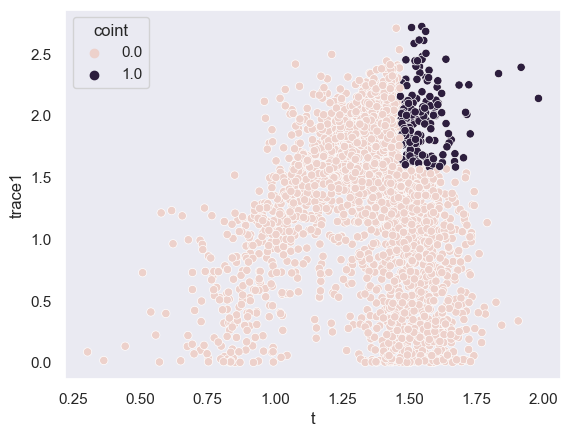

In [354]:
sns.scatterplot(x=np.log1p(spreads.t.abs()), 
                y=np.log1p(spreads.trace1), 
                hue='coint', data=spreads[spreads.trace0>trace0_cv]);

In [355]:
spreads.to_hdf('heuristics.h5', 'spreads')

In [356]:
spreads = pd.read_hdf('heuristics.h5', 'spreads')

### Heuristics 평가하기

In [357]:
spreads.drift = spreads.drift.abs()

In [358]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig      0    1
eg_sig               
0          20431  720
1           1384  169

In [359]:
pd.set_option('display.float_format', lambda x: f'{x:.2%}')
pd.crosstab(spreads.eg_sig, spreads.trace_sig, normalize=True)

trace_sig      0     1
eg_sig                
0         89.99% 3.17%
1          6.10% 0.74%

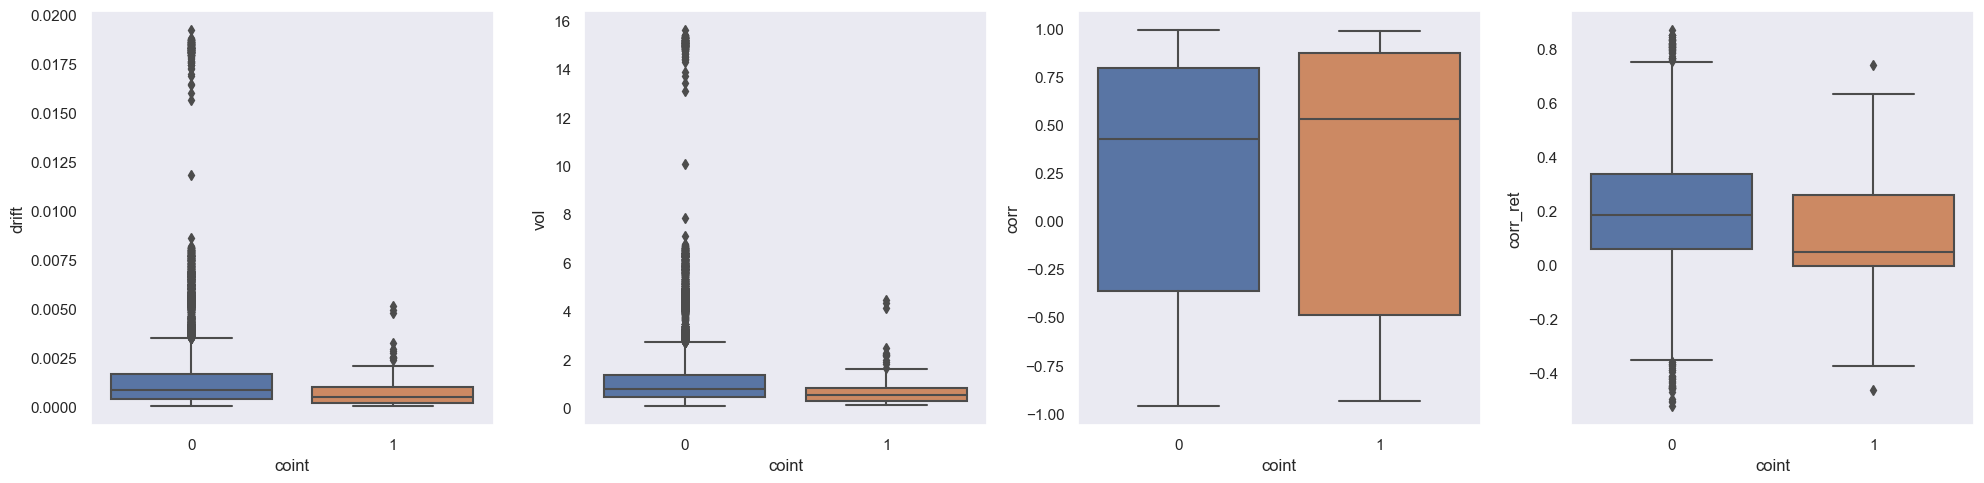

In [360]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for i, heuristic in enumerate(['drift', 'vol', 'corr', 'corr_ret']):
    sns.boxplot(x='coint', y=heuristic, data=spreads, ax=axes[i])
fig.tight_layout();

### 휴리스틱이 유의한 공적분을 얼마나 잘 예측할까?

두 검정 모두에 따라 공적분된 시계열에 대한 휴리스틱 분포를 공적분되지 않은 나머지 시계열과 비교하면 변동성과 드리프트가 실제로 낮습니다(절대값 기준). 그림 9.14는 두 상관 관계 측도의 경우 그림이 덜 명확함을 보여줍니다.

In [362]:
spreads

s1        s2  drift     vol    corr  corr_ret     n       t1  \
0      SPY.US   AAPL.US  0.19% 152.82%  96.24%    12.78%  2516 -170.97%   
1      SPY.US   AMZN.US  0.45% 371.26%  93.47%    13.58%  2516 -170.56%   
2      SPY.US   MSFT.US  0.08%  80.65%  93.95%    16.85%  2516 -132.99%   
3      SPY.US    BAC.US  0.03%  28.67%  91.37%    15.96%  2516 -289.67%   
4      SPY.US  GOOGL.US  0.05%  40.62%  98.30%    14.24%  2516 -357.67%   
...       ...       ...    ...     ...     ...       ...   ...      ...   
22699  EWN.US    GPS.US  0.03%  46.32%  25.94%    19.03%  2516   28.16%   
22700  EWN.US   ADSK.US  0.17% 141.35%  91.77%    30.95%  2516 -248.73%   
22701  EWN.US   FSLR.US  0.06%  43.90% -21.49%    19.71%  2516  -39.33%   
22702  EWN.US    ADI.US  0.10%  77.15%  94.84%    32.57%  2516 -284.85%   
22703  EWN.US    PCG.US  0.03%  48.47%   5.65%     6.79%  2516   -2.77%   

          p1       t2     p2  k_ar_diff   trace0  trace1  \
0     67.25% -119.34% 85.96%          9  594.33%  31.24%   
1     67.44% -168.09% 68.56%          9  523.21%  37.60%   
2     82.05%  -18.89% 98.04%          9 2871.82%  96.19%   
3     13.68% -267.17% 20.99%          9  877.80%  12.99%   
4      2.62% -355.85%  2.75%         12 1234.28%  93.03%   
...      ...      ...    ...        ...      ...     ...   
22699 99.07% -153.70% 74.67%          6  489.02%   0.03%   
22700 28.47% -222.29% 41.26%          6  689.14%  24.53%   
22701 97.11% -218.23% 43.35%         19  586.33%  76.65%   
22702 15.07% -279.42% 16.75%          6  955.17%   9.61%   
22703 98.52%  -49.92% 96.44%          5  390.20%   2.01%   

                              name1            name2        t      p  \
0            SPDR S&P 500 ETF TRUST            APPLE -170.97% 67.25%   
1            SPDR S&P 500 ETF TRUST       AMAZON.COM -170.56% 67.44%   
2            SPDR S&P 500 ETF TRUST        MICROSOFT -132.99% 82.05%   
3            SPDR S&P 500 ETF TRUST  BANK OF AMERICA -289.67% 13.68%   
4            SPDR S&P 500 ETF TRUST         ALPHABET -357.67%  2.62%   
...                             ...              ...      ...    ...   
22699  ISHARES MSCI NETHERLANDS ETF              GAP -153.70% 74.67%   
22700  ISHARES MSCI NETHERLANDS ETF         AUTODESK -248.73% 28.47%   
22701  ISHARES MSCI NETHERLANDS ETF      FIRST SOLAR -218.23% 43.35%   
22702  ISHARES MSCI NETHERLANDS ETF   ANALOG DEVICES -284.85% 15.07%   
22703  ISHARES MSCI NETHERLANDS ETF             PG&E  -49.92% 96.44%   

       trace_sig  eg_sig  coint  
0              0       0      0  
1              0       0      0  
2              0       0      0  
3              0       0      0  
4              0       1      0  
...          ...     ...    ...  
22699          0       0      0  
22700          0       0      0  
22701          0       0      0  
22702          0       0      0  
22703          0       0      0  

[22704 rows x 21 columns]

In [366]:
spreads.groupby(spreads.coint)[['drift', 'vol', 'corr']].describe().stack(level=0).swaplevel().sort_index()

count    mean     std     min     25%    50%     75%  \
      coint                                                              
corr  0     2253500.00%  23.25%  61.01% -96.43% -36.41% 42.96%  79.61%   
      1       16900.00%  24.47%  69.62% -93.41% -48.88% 53.09%  87.50%   
drift 0     2253500.00%   0.13%   0.18%   0.00%   0.04%  0.09%   0.16%   
      1       16900.00%   0.08%   0.09%   0.00%   0.02%  0.05%   0.10%   
vol   0     2253500.00% 116.27% 147.76%   5.92%  43.96% 76.79% 135.44%   
      1       16900.00%  71.71%  70.31%  10.14%  28.35% 54.14%  82.92%   

                 max  
      coint           
corr  0       99.43%  
      1       98.83%  
drift 0        1.92%  
      1        0.51%  
vol   0     1559.97%  
      1      446.41%

In [367]:
spreads.coint.value_counts()

coint
0    22535
1      169
Name: count, dtype: int64

#### 로지스틱 회귀

휴리스틱의 예측 정확도를 평가하기 위해 먼저 이러한 특징을 사용하여 유의한 공적분을 예측하는 로지스틱 회귀 모델을 실행합니다. 이는 0.815의 면적-아래-곡선(AUC) 교차 검증 점수를 달성합니다. 상관 관계 지표를 제외하더라도 여전히 0.804점을 기록합니다. 의사 결정 트리는 상관 관계 특징이 있든 없든 AUC=0.821에서 약간 더 나은 성능을 보입니다.

In [368]:
y = spreads.coint
X = spreads[['drift', 'vol', 'corr', 'corr_ret']]
# X = spreads[['drift', 'vol']]

In [369]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [370]:
log_reg = LogisticRegressionCV(Cs=np.logspace(-10, 10, 21), 
                               class_weight='balanced',
                               scoring='roc_auc')

'C:-9.00, AUC: 61.32%'

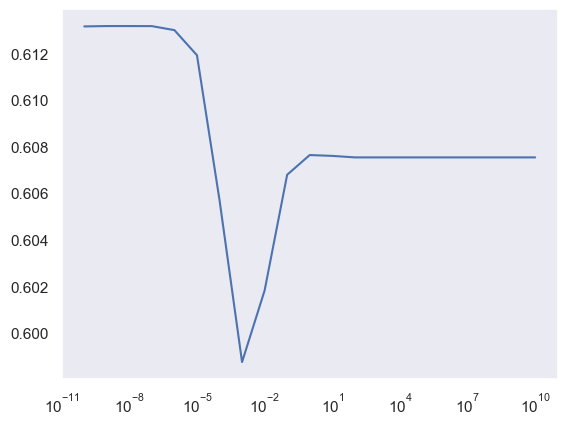

In [371]:
log_reg.fit(X=X, y=y)
Cs = log_reg.Cs_
scores = pd.DataFrame(log_reg.scores_[True], columns=Cs).mean()
scores.plot(logx=True);
f'C:{np.log10(scores.idxmax()):.2f}, AUC: {scores.max():.2%}'

In [372]:
log_reg.coef_

array([[-3.01636507e-09, -2.52891720e-06,  6.92673499e-08,
        -3.75322339e-07]])

In [373]:
y_pred = log_reg.predict_proba(X)[:, 1]
confusion_matrix(y_true=spreads.coint, y_pred=(y_pred>.5))

array([[22535,     0],
       [  169,     0]], dtype=int64)

In [374]:
spreads.assign(y_pred=log_reg.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

count   mean   std    min    25%    50%    75%    max
coint                                                            
0     2253500.00% 50.00% 0.00% 50.00% 50.00% 50.00% 50.00% 50.00%
1       16900.00% 50.00% 0.00% 50.00% 50.00% 50.00% 50.00% 50.00%

클래스 불균형이 심한 것도 있지만, 오탐이 많이 발생합니다. 366개의 공적분 쌍 중 80%를 정확하게 식별한다는 것은 16,500개 이상의 오탐을 의미하지만, 후보자의 거의 30,000개를 제거합니다. 추가적인 세부 정보는 공적분_검정 노트북을 참조하세요.


가장 중요한 점은 거리 휴리스틱이 대규모 유니버스를 더 효율적으로 스크리닝하는 데 도움이 될 수 있지만, 이는 일부 공적분 쌍을 놓치는 대가를 치르며 여전히 상당한 테스트가 필요하다는 것입니다.

#### Decision Tree 분류기

In [375]:
model = DecisionTreeClassifier(class_weight='balanced')
decision_tree = GridSearchCV(model,
                             param_grid={'max_depth': list(range(1, 10))},
                             cv=5,
                             scoring='roc_auc')

In [376]:
decision_tree.fit(X=X, y=y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc')

In [377]:
f'{decision_tree.best_score_:.2%}, Depth: {decision_tree.best_params_["max_depth"]}'

'70.18%, Depth: 3'

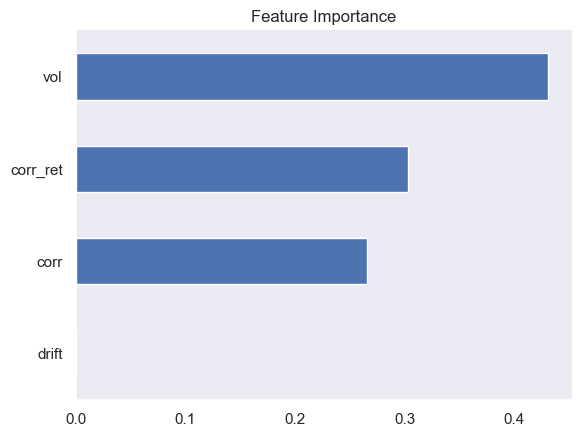

In [378]:
pd.Series(data=decision_tree.best_estimator_.feature_importances_, 
          index=X.columns).sort_values().plot.barh(title='Feature Importance')
sns.despine();

In [379]:
spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

count   mean    std    min    25%    50%    75%    max
coint                                                             
0     2253500.00% 35.11% 19.08%  0.00% 25.08% 25.08% 25.31% 96.49%
1       16900.00% 64.89% 26.19% 25.08% 25.31% 69.88% 91.74% 96.49%

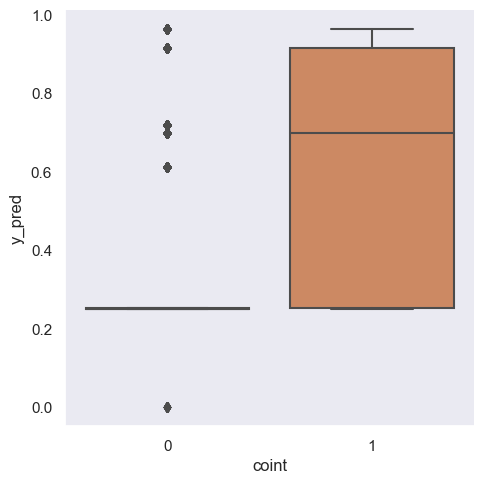

In [380]:
sns.catplot(x='coint', 
            y='y_pred', 
            data=spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]), 
            kind='box');

# 공적분을 이용한 통계적 차익거래

## 페어 트레이딩 과 통계적 차익거래 (Statistical Arbitrage)

통계적 차익거래는 자산의 상대적 오프라이싱을 이용하여 이익을 얻는 통계적 모델이나 방법을 사용하는 전략을 말하며, 동시에 시장 중립성을 유지합니다.


페어 트레이딩은 적어도 80년대 중반부터 알고리즘 트레이더들이 사용해 온 개념적으로 간단한 전략입니다([Gatev, Goetzmann, and Rouwenhorst 2006](http://www-stat.wharton.upenn.edu/~steele/Courses/434/434Context/PairsTrading/PairsTradingGGR.pdf)).  목표는 역사적으로 가격이 함께 움직인 두 자산을 찾고, 스프레드(가격 차이)를 추적하고, 스프레드가 넓어지면 공통 추세 아래로 떨어진 패자를 사고 승자를 숏하는 것입니다. 관계가 지속되면 롱 및/또는 숏 레그는 가격이 수렴하고 포지션이 청산됨에 따라 수익을 창출합니다.


이 접근 방식은 여러 증권으로 바스켓을 구성하고 한 자산을 두 바스켓의 바스켓에 대해 거래하고 서로에 대해 두 바스켓을 거래함으로써 다변량 맥락으로 확장됩니다.

## 실무에서의 페어 트레이딩

실무에서 이 전략에는 두 단계가 필요합니다.

- **포메이션 단계**: 장기적인 평균 회귀 관계가 있는 증권을 식별합니다. 이상적으로 스프레드는 공통 추세로 안정적으로 회귀하면서도 수익성 있는 거래를 자주 할 수 있도록 높은 분산을 가져야 합니다.
- **거래 단계**: 가격 움직임으로 인해 스프레드가 발산하고 수렴하면 진입 및 종료 거래 규칙을 트리거합니다.

지난 수년간 여러 자산 클래스에 걸쳐 이 분야에서 연구가 활발해지면서 포메이션 및 거래 단계에 대한 여러 접근 방식이 등장했습니다. 이 책에서는 그들 사이의 주요 차이점을 설명합니다. 노트북은 예제 응용 프로그램을 자세히 살펴봅니다.

In [381]:
import warnings
warnings.filterwarnings('ignore')

In [385]:
from collections import Counter

from time import time
from pathlib import Path

import numpy as np
import pandas as pd

from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [386]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

In [387]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

### Johansen 검정 임계값

In [388]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [389]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

In [390]:
DATA_PATH = Path('..', 'data') 
STORE = DATA_PATH / 'assets.h5'

Combine OHLCV prices for relevant stock and ETF tickers.

In [395]:
def get_backtest_prices():
    with pd.HDFStore('data.h5') as store:
        tickers = store['tickers']

    with pd.HDFStore(STORE) as store:
        prices = (pd.concat([
            store['stooq/us/nyse/stocks/prices'],
            store['stooq/us/nyse/etfs/prices'],
            store['stooq/us/nasdaq/etfs/prices'],
            store['stooq/us/nasdaq/stocks/prices']])
                  .sort_index()
                  .loc[idx[tickers.index, '2016':'2019'], :])
    print(prices.isna().sum())
    prices.to_hdf('backtest.h5', 'prices')
    tickers.to_hdf('backtest.h5', 'tickers')

In [396]:
get_backtest_prices()

open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [397]:
# see notebook 05_cointagration_tests
stocks = pd.read_hdf('data.h5', 'stocks/close').loc['2015':]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 172 entries, AAPL.US to PCG.US
dtypes: float64(172)
memory usage: 1.7 MB


In [398]:
# see notebook 05_cointagration_tests (공적분 검정)
etfs = pd.read_hdf('data.h5', 'etfs/close').loc['2015':]
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 132 entries, SPY.US to EWN.US
dtypes: float64(132)
memory usage: 1.3 MB


In [399]:
names = pd.read_hdf('data.h5', 'tickers').to_dict()

In [400]:
pd.Series(names).count()

304

In [401]:
def test_cointegration(etfs, stocks, test_end, lookback=2):
    start = time()
    results = []
    test_start = test_end - pd.DateOffset(years=lookback) + pd.DateOffset(days=1)
    etf_tickers = etfs.columns.tolist()
    etf_data = etfs.loc[str(test_start):str(test_end)]

    stock_tickers = stocks.columns.tolist()
    stock_data = stocks.loc[str(test_start):str(test_end)]
    n = len(etf_tickers) * len(stock_tickers)
    j = 0
    for i, s1 in enumerate(etf_tickers, 1):
        for s2 in stock_tickers:
            j += 1
            if j % 1000 == 0:
                print(f'\t{j:5,.0f} ({j/n:3.1%}) | {time() - start:.2f}')
            df = etf_data.loc[:, [s1]].dropna().join(stock_data.loc[:, [s2]].dropna(), how='inner')
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                var = VAR(df)
                lags = var.select_order()
                result = [test_end, s1, s2]
                order = lags.selected_orders['aic']
                result += [coint(df[s1], df[s2], trend='c')[1], coint(df[s2], df[s1], trend='c')[1]]

            cj = coint_johansen(df, det_order=0, k_ar_diff=order)
            result += (list(cj.lr1) + list(cj.lr2) + list(cj.evec[:, cj.ind[0]]))
            results.append(result)
    return results

In [402]:
'''테스트기간지정'''
dates = stocks.loc['2016-12':'2019-6'].resample('Q').last().index
dates

DatetimeIndex(['2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30',
               '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30',
               '2018-12-31', '2019-03-31', '2019-06-30'],
              dtype='datetime64[ns]', name='date', freq='QE-DEC')

In [ ]:
'''테스트진행'''
test_results = []
columns = ['test_end', 's1', 's2', 'eg1', 'eg2',
           'trace0', 'trace1', 'eig0', 'eig1', 'w1', 'w2']

for test_end in dates:
    print(test_end)
    result = test_cointegration(etfs, stocks, test_end=test_end)
    test_results.append(pd.DataFrame(result, columns=columns))

pd.concat(test_results).to_hdf('backtest.h5', 'cointegration_test')

2016-12-31 00:00:00
	1,000 (4.4%) | 47.19
	2,000 (8.8%) | 94.03
	3,000 (13.2%) | 140.66
	4,000 (17.6%) | 186.57
	5,000 (22.0%) | 232.71
	6,000 (26.4%) | 278.36
	7,000 (30.8%) | 324.38
	8,000 (35.2%) | 370.29
	9,000 (39.6%) | 416.04
	10,000 (44.0%) | 462.04
	11,000 (48.4%) | 507.95
	12,000 (52.9%) | 553.12
	13,000 (57.3%) | 598.72
	14,000 (61.7%) | 643.62
	15,000 (66.1%) | 688.92
	16,000 (70.5%) | 733.51
	17,000 (74.9%) | 779.49
	18,000 (79.3%) | 825.25
	19,000 (83.7%) | 870.37
	20,000 (88.1%) | 916.48
	21,000 (92.5%) | 962.37
	22,000 (96.9%) | 1007.77
2017-03-31 00:00:00
	1,000 (4.4%) | 45.58
	2,000 (8.8%) | 91.24
	3,000 (13.2%) | 138.38
	4,000 (17.6%) | 184.53
	5,000 (22.0%) | 230.68
	6,000 (26.4%) | 277.90
	7,000 (30.8%) | 322.96
	8,000 (35.2%) | 367.81
	9,000 (39.6%) | 413.58
	10,000 (44.0%) | 458.88
	11,000 (48.4%) | 504.94
	12,000 (52.9%) | 550.24
	13,000 (57.3%) | 595.65
	14,000 (61.7%) | 640.99
	15,000 (66.1%) | 686.14
	16,000 (70.5%) | 731.14
	17,000 (74.9%) | 776.43
	18,000 (7

In [ ]:
'''테스트결과'''
test_results = pd.read_hdf('backtest.h5', 'cointegration_test')
test_results.info()

## 공적분 쌍 식별

### 유의한 Johansen 추적 통계량

In [ ]:
test_results['joh_sig'] = ((test_results.trace0 > trace0_cv) &
                           (test_results.trace1 > trace1_cv))

In [ ]:
test_results.joh_sig.value_counts(normalize=True)

### 유의한 Engle-Granger 검정

In [ ]:
test_results['eg'] = test_results[['eg1', 'eg2']].min(axis=1)
test_results['s1_dep'] = test_results.eg1 < test_results.eg2
test_results['eg_sig'] = (test_results.eg < .05)

In [ ]:
test_results.eg_sig.value_counts(normalize=True)

### Engle-Granger, Johansen 검정 비교하기

In [ ]:
test_results['coint'] = (test_results.eg_sig & test_results.joh_sig)
test_results.coint.value_counts(normalize=True)

In [ ]:
test_results = test_results.drop(['eg1', 'eg2', 'trace0', 'trace1', 'eig0', 'eig1'], axis=1)
test_results.info()

In [ ]:
ax = test_results.groupby('test_end').coint.mean().to_frame('# Pairs').plot()
ax.axhline(.05, lw=1, ls='--', c='k');

### Select Candidate Pairs

In [ ]:
def select_candidate_pairs(data):
    candidates = data[data.joh_sig | data.eg_sig]
    candidates['y'] = candidates.apply(lambda x: x.s1 if x.s1_dep else x.s2, axis=1)
    candidates['x'] = candidates.apply(lambda x: x.s2 if x.s1_dep else x.s1, axis=1)
    return candidates.drop(['s1_dep', 's1', 's2'], axis=1)

In [ ]:
candidates = select_candidate_pairs(test_results)

In [ ]:
candidates.to_hdf('backtest.h5', 'candidates')

In [ ]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

In [ ]:
'''시간별 후보군'''
candidates.groupby('test_end').size().plot(figsize=(8, 5))

#### Most Common Pairs 

In [ ]:
with pd.HDFStore('data.h5') as store:
    print(store.info())
    tickers = store['tickers']

In [ ]:
with pd.HDFStore('backtest.h5') as store:
    print(store.info())

In [ ]:
counter = Counter()
for s1, s2 in zip(candidates[candidates.joh_sig & candidates.eg_sig].y, 
                  candidates[candidates.joh_sig & candidates.eg_sig].x):
    if s1 > s2:
        counter[(s2, s1)] += 1
    else: 
        counter[(s1, s2)] += 1

In [ ]:
most_common_pairs = pd.DataFrame(counter.most_common(10))
most_common_pairs = pd.DataFrame(most_common_pairs[0].values.tolist(), columns=['s1', 's2'])
most_common_pairs

In [ ]:
with pd.HDFStore('backtest.h5') as store:
    prices = store['prices'].close.unstack('ticker').ffill(limit=5)
    tickers = store['tickers'].to_dict()

In [ ]:
cnt = pd.Series(counter).reset_index()
cnt.columns = ['s1', 's2', 'n']
cnt['name1'] = cnt.s1.map(tickers)
cnt['name2'] = cnt.s2.map(tickers)
cnt.nlargest(10, columns='n')

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for i in [0, 1]:
    s1, s2 = most_common_pairs.at[i, 's1'], most_common_pairs.at[i, 's2']
    prices.loc[:, [s1, s2]].rename(columns=tickers).plot(secondary_y=tickers[s2],
                                                         ax=axes[i],
                                                         rot=0)
    axes[i].grid(False)
    axes[i].set_xlabel('')

sns.despine()
fig.tight_layout()

## Entry 및 Exit 날짜 가져오기

In [ ]:
def KFSmoother(prices):
    """칼만 필터를 사용하여 가격 매끄럽게 하기"""
    
    kf = KalmanFilter(transition_matrices=np.eye(1),
                      observation_matrices=np.eye(1),
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=.05)

    state_means, _ = kf.filter(prices.values)
    return pd.Series(state_means.flatten(),
                     index=prices.index)

In [ ]:
smoothed_prices = prices.apply(KFSmoother)
smoothed_prices.to_hdf('tmp.h5', 'smoothed')

In [ ]:
smoothed_prices = pd.read_hdf('tmp.h5', 'smoothed')

In [ ]:
def KFHedgeRatio(x, y):
    """칼만 필터를 사용하여 롤링 헤지 비율 계산"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    state_means, _ = kf.filter(y.values)
    return -state_means

In [ ]:
'''평균 회귀 반감기를 추정
스프레드를 연속 시간에서 의 평균 회귀 확 률 적 프 로 세 스 로 본다면 
그것을 온스타인 - 울렌벡 프로세스 로 모델링 할 수 있다. 이러한 관점 에서 볼 때 편차가 발생한 후 
스프레드 가 다시 수렴 되는 데 필요한 시간의 근사치 로 서 평균 반감기의 공식을 얻을 수 있다).
'''
def estimate_half_life(spread):
    X = spread.shift().iloc[1:].to_frame().assign(const=1)
    y = spread.diff().iloc[1:]
    beta = (np.linalg.inv(X.T @ X) @ X.T @ y).iloc[0]
    halflife = int(round(-np.log(2) / beta, 0))
    return max(halflife, 1)

### Compute Spread & Bollinger Bands

In [ ]:
def get_spread(candidates, prices):
    pairs = []
    half_lives = []

    periods = pd.DatetimeIndex(sorted(candidates.test_end.unique()))
    start = time()
    for p, test_end in enumerate(periods, 1):
        start_iteration = time()

        period_candidates = candidates.loc[candidates.test_end == test_end, ['y', 'x']]
        trading_start = test_end + pd.DateOffset(days=1)
        t = trading_start - pd.DateOffset(years=2)
        T = trading_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
        max_window = len(prices.loc[t: test_end].index)
        print(test_end.date(), len(period_candidates))
        for i, (y, x) in enumerate(zip(period_candidates.y, period_candidates.x), 1):
            if i % 1000 == 0:
                msg = f'{i:5.0f} | {time() - start_iteration:7.1f} | {time() - start:10.1f}'
                print(msg)
            pair = prices.loc[t: T, [y, x]]
            pair['hedge_ratio'] = KFHedgeRatio(y=KFSmoother(prices.loc[t: T, y]),
                                               x=KFSmoother(prices.loc[t: T, x]))[:, 0]
            pair['spread'] = pair[y].add(pair[x].mul(pair.hedge_ratio))
            half_life = estimate_half_life(pair.spread.loc[t: test_end])                

            spread = pair.spread.rolling(window=min(2 * half_life, max_window))
            pair['z_score'] = pair.spread.sub(spread.mean()).div(spread.std())
            pairs.append(pair.loc[trading_start: T].assign(s1=y, s2=x, period=p, pair=i).drop([x, y], axis=1))

            half_lives.append([test_end, y, x, half_life])
    return pairs, half_lives

In [ ]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

In [ ]:
pairs, half_lives = get_spread(candidates, smoothed_prices)

### Collect Results

In [ ]:
'''
 Half Lives
'''
hl = pd.DataFrame(half_lives, columns=['test_end', 's1', 's2', 'half_life'])
hl.info()

In [ ]:
hl.half_life.describe()

In [ ]:
hl.to_hdf('backtest.h5', 'half_lives')

In [ ]:
pair_data = pd.concat(pairs)
pair_data.info(null_counts=True)

In [ ]:
pair_data.to_hdf('backtest.h5', 'pair_data')

In [ ]:
pair_data = pd.read_hdf('backtest.h5', 'pair_data')

### Identify Long & Short Entry and Exit Dates

In [ ]:
def get_trades(data):
    pair_trades = []
    for i, ((period, s1, s2), pair) in enumerate(data.groupby(['period', 's1', 's2']), 1):
        if i % 100 == 0:
            print(i)

        first3m = pair.first('3M').index
        last3m = pair.last('3M').index

        entry = pair.z_score.abs() > 2
        entry = ((entry.shift() != entry)
                 .mul(np.sign(pair.z_score))
                 .fillna(0)
                 .astype(int)
                 .sub(2))

        exit = (np.sign(pair.z_score.shift().fillna(method='bfill'))
                != np.sign(pair.z_score)).astype(int) - 1

        trades = (entry[entry != -2].append(exit[exit == 0])
                  .to_frame('side')
                  .sort_values(['date', 'side'])
                  .squeeze())
        if not isinstance(trades, pd.Series):
            continue
        try:
            trades.loc[trades < 0] += 2
        except:
            print(type(trades))
            print(trades)
            print(pair.z_score.describe())
            break

        trades = trades[trades.abs().shift() != trades.abs()]
        window = trades.loc[first3m.min():first3m.max()]
        extra = trades.loc[last3m.min():last3m.max()]
        n = len(trades)

        if window.iloc[0] == 0:
            if n > 1:
                print('shift')
                window = window.iloc[1:]
        if window.iloc[-1] != 0:
            extra_exits = extra[extra == 0].head(1)
            if extra_exits.empty:
                continue
            else:
                window = window.append(extra_exits)

        trades = pair[['s1', 's2', 'hedge_ratio', 'period', 'pair']].join(window.to_frame('side'), how='right')
        trades.loc[trades.side == 0, 'hedge_ratio'] = np.nan
        trades.hedge_ratio = trades.hedge_ratio.ffill()
        pair_trades.append(trades)
    return pair_trades

In [ ]:
pair_trades = get_trades(pair_data)

In [ ]:
pair_trade_data = pd.concat(pair_trades)
pair_trade_data.info()

In [ ]:
pair_trade_data.head()

In [ ]:
trades = pair_trade_data['side'].copy()
trades.loc[trades != 0] = 1
trades.loc[trades == 0] = -1
trades.sort_index().cumsum().plot(figsize=(14, 4))
sns.despine()

In [ ]:
pair_trade_data.to_hdf('backtest.h5', 'pair_trades')

# 페어 트레이딩: 백트레이더로 백테스트

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import csv
from collections import defaultdict
from dataclasses import dataclass, asdict
from datetime import date
from pathlib import Path
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [ ]:

sns.set_style('dark')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
idx = pd.IndexSlice

In [ ]:
STORE = 'backtest.h5'

In [ ]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Pairs Trading Backtest

### Pairs DataClass

In [ ]:
'''
Pairs DataClass
'''
@dataclass
class Pair:
    period: int
    s1: str
    s2: str
    size1: float
    size2: float
    long: bool
    hr: float
    p1: float
    p2: float
    pos1: float
    pos2: float
    exec1: bool = False
    exec2: bool = False
    active: bool = False
    entry_date: date = None
    exit_date: date = None
    entry_spread: float = np.nan
    exit_spread: float = np.nan

    def executed(self):
        return self.exec1 and self.exec2

    def get_constituent(self, name):
        if name == self.s1:
            return 1
        elif name == self.s2:
            return 2
        else:
            return 0

    def compute_spread(self, p1, p2):
        return p1 * self.size1 + p2 * self.size2

    def compute_spread_return(self, p1, p2):
        current_spread = self.compute_spread(p1, p2)
        delta = self.entry_spread - current_spread
        return (delta / (np.sign(self.entry_spread) *
                         self.entry_spread))

In [ ]:
class CustomData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = ['open', 'high', 'low', 'close', 'volume']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [ ]:
'''
Define Trading Strategy
'''
class StatisticalArbitrageCointegration(bt.Strategy):
    '''통계적 아비트라주 공적분 거래 전략을 정의합니다.'''
    params = (('trades', None),
              ('risk_limit', -.2),
              ('verbose', True),
              ('log_file', 'backtest.csv'))

    def __init__(self):
        self.active_pairs = {}
        self.closing_pairs = {}
        self.exposure = []
        self.metrics = []
        self.last_close = {}
        self.cnt = 0
        self.today = None
        self.clear_log()
        self.order_status = dict(enumerate(['Created', 'Submitted', 'Accepted',
                                            'Partial', 'Completed', 'Canceled',
                                            'Expired', 'Margin', 'Rejected']))

    def clear_log(self):
        ''' 로그 파일을 지웁니다.'''
        if Path(self.p.log_file).exists():
            Path(self.p.log_file).unlink()
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow(
                    ['Date', 'Pair', 'Symbol', 'Order #', 'Reason',
                     'Status', 'Long', 'Price', 'Size', 'Position'])

    def log(self, txt, dt=None):
        """  전략에 대한 로거입니다."""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.date()] + txt.split(','))

    def get_pair_id(self, s1, s2, period):
        ''' 주어진 두 기초 자산과 기간을 기반으로 쌍 ID를 반환'''
        
        return f'{s1}.{s2}.{period}'

    def check_risk_limit(self):
        '''모든 활성 쌍에 대해 위험 한도를 확인하고 위험 한도를 초과하는 쌍을 청산'''
        for pair_id, pair in list(self.active_pairs.items()):
            if pair.active:
                p1 = self.last_close.get(pair.s1)
                p2 = self.last_close.get(pair.s2)
                ret = pair.compute_spread_return(p1, p2)
                if ret < self.p.risk_limit:
                    self.log(f'{pair_id},{pair.s1},{pair.s2},Risk Limit,{ret},')
                    del self.active_pairs[pair_id]
                    self.sell_pair(pair_id, pair)

    def sell_pair(self, pair_id, pair, reason='close'):
        '''주어진 쌍 ID와 쌍을 기반으로 쌍을 청산합니다.'''
        info = {'pair': pair_id, 'type': reason}
        if pair.long:
            o1 = self.sell(data=pair.s1, size=abs(pair.size1), info=info)
            o2 = self.buy(data=pair.s2, size=abs(pair.size2), info=info)
        else:
            o1 = self.buy(data=pair.s1, size=abs(pair.size1), info=info)
            o2 = self.sell(data=pair.s2, size=abs(pair.size2), info=info)
        pair.active = False
        pair.exec1 = pair.exec2 = False
        self.closing_pairs[pair_id] = pair

        self.log(f'{pair_id},{pair.s1},{o1.ref},{reason},Created,{pair.long},,{pair.size1},')
        self.log(f'{pair_id},{pair.s2},{o2.ref},{reason},Created,{pair.long},,{pair.size2},')

    def notify_order(self, order):
        '''주문에 대한 알림을 처리합니다.'''
        symbol = order.data._name
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            p = order.executed.price
            s = order.executed.size
            order_type = order.info.info['type']
            if order_type in ['open', 'close']:
                pair_id = order.info.info['pair']
                if order_type == 'open':
                    pair = self.active_pairs.get(pair_id)
                else:
                    pair = self.closing_pairs.get(pair_id)
                if pair is None:
                    self.log(f'{pair_id},{symbol},{order.ref},{order_type},Completed (missing),,{p},{s},{p * s}')
                    return
                component = pair.get_constituent(symbol)
                if component == 1:
                    pair.p1 = p
                    pair.exec1 = True
                elif component == 2:
                    pair.p2 = p
                    pair.exec2 = True
                if pair.executed():
                    pair.exec1 = False
                    pair.exec2 = False
                    if order_type == 'open':
                        pair.entry_spread = pair.compute_spread(p1=pair.p1, p2=pair.p2)
                        pair.entry_date = self.today
                        pair.active = True
                    elif order_type == 'close':
                        pair.exit_spread = pair.compute_spread(p1=pair.p1, p2=pair.p2)
                        pair.exit_date = self.today
                        pair.active = False
                        self.closing_pairs.pop(pair_id)
                self.log(f'{pair_id},{symbol},{order.ref},{order_type},Completed,{pair.long},{p},{s},{p * s}')
            else:
                self.log(f',{symbol},{order.ref},{order_type},Completed,,{p},{s},{p * s}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            order_type = order.info.info['type']
            self.log(f',{symbol},{order.ref},{order_type},{self.order_status[order.status]},,,,')

    def enter_pairs(self, df, long=True):
        '''주어진 데이터프레임에서 쌍을 입력'''
        for s1, s2, hr, period in zip(df.s1, df.s2, df.hedge_ratio, df.period):
            pair_id = self.get_pair_id(s1, s2, period)
            if self.active_pairs.get(pair_id):
                continue

            p1 = self.last_close[s1]
            p2 = self.last_close[s2]
            if long:
                size1 = self.target_value / p1
                size2 = hr * size1
            else:
                size2 = self.target_value / p2
                size1 = 1 / hr * size2

            pair = Pair(s1=s1, s2=s2, period=period, size1=size1, size2=size2,
                        pos1=p1 * size1, pos2=p2 * size2,
                        hr=hr, long=long, p1=p1, p2=p2, entry_date=self.today)
            info = {'pair': pair_id, 'type': 'open'}
            if long:
                o1 = self.buy(data=s1, size=size1, info=info)
                o2 = self.sell(data=s2, size=abs(size2), info=info)
            else:
                o1 = self.sell(data=pair.s1, size=abs(pair.size1), info=info)
                o2 = self.buy(data=pair.s2, size=abs(pair.size2), info=info)

            self.active_pairs[pair_id] = pair

            self.log(f'{pair_id},{s1},{o1.ref},Open,Created,{long},{p1},{size1},{pair.pos1}')
            self.log(f'{pair_id},{s2},{o2.ref},Open,Created,{long},{p2},{size2},{pair.pos2}')

    def adjust_pairs(self):
        orders = defaultdict(float)
        pairs = defaultdict(list)
        for pair_id, pair in self.active_pairs.items():
            p1, p2 = self.last_close[pair.s1], self.last_close[pair.s2]
            pos1, pos2 = pair.size1 * p1, pair.size2 * p2

            if pair.long:
                target_size1 = self.target_value / p1
                orders[pair.s1] += target_size1 - pair.size1
                target_size2 = pos2 / pos1 * self.target_value / p2
                orders[pair.s2] += target_size2 - pair.size2
            else:
                target_size2 = self.target_value / p2
                orders[pair.s2] += target_size2 - pair.size2
                target_size1 = pos1 / pos2 * self.target_value / p1
                orders[pair.s1] += target_size1 - pair.size1
            pair.size1 = target_size1
            pair.size2 = target_size2
            pairs[pair.s1].append(pair_id)
            pairs[pair.s2].append(pair_id)

        for symbol, size in orders.items():
            info = {'pairs': pairs[symbol], 'type': 'adjust'}
            if size > 0:
                order = self.buy(symbol, size=size, info=info)
            elif size < 0:
                order = self.sell(symbol, size=abs(size), info=info)
            else:
                continue
            self.log(f',{symbol},{order.ref},Adjust,Created,{size}')

    def prenext(self):
        self.next()

    def next(self):
        self.today = pd.Timestamp(self.datas[0].datetime.date())
        if self.today not in self.p.trades.index:
            return
        self.cnt += 1

        pf = self.broker.get_value()
        cash = self.broker.get_cash()

        exp = {d._name: pos.size for d, pos in self.getpositions().items() if pos}
        self.last_close = {d._name: d.close[0] for d in self.datas}
        exposure = pd.DataFrame({'price'   : pd.Series(self.last_close),
                                 'position': pd.Series(exp)}).replace(0, np.nan).dropna()
        exposure['value'] = exposure.price * exposure.position
        positions = exposure.value.to_dict()
        positions['date'] = self.today
        positions['cash'] = cash
        if not exposure.empty:
            self.exposure.append(positions)
            long_pos = exposure[exposure.value > 0].value.sum()
            short_pos = exposure[exposure.value < 0].value.sum()
            for symbol, row in exposure.iterrows():
                self.log(f',{symbol},,Positions,Log,,{row.price},{row.position},{row.value}')
        else:
            long_pos = short_pos = 0

        trades = self.p.trades.loc[self.today]
        if isinstance(trades, pd.Series):
            trades = trades.to_frame().T

        close = trades[trades.side == 0].sort_values('period')
        for s1, s2, period in zip(close.s1, close.s2, close.period):
            pair_id = self.get_pair_id(s1, s2, period)
            pair = self.active_pairs.pop(pair_id, None)
            if pair is None:
                self.log(f'{pair_id},,,Close Attempt,Failed,,,,')
                continue
            self.sell_pair(pair_id, pair)

        if len(self.active_pairs) > 0:
            self.check_risk_limit()

        long = trades[trades.side == 1]
        short = trades[trades.side == -1]
        if long.empty and short.empty: return
        target = 1 / (len(long) + len(short) + len(self.active_pairs))
        self.target_value = pf * target
        metrics = [self.today, pf, pf - cash, cash, len(exposure), len(self.active_pairs), long_pos, short_pos,
                   target, self.target_value, len(long), len(short), len(close)]
        self.metrics.append(metrics)
        if self.cnt % 21 == 0:
            holdings = pf - cash
            msg = f'PF: {pf:11,.0f} | Net: {holdings: 11,.0f} | # Pos: {len(exposure):3,.0f} | # Pairs: {len(self.active_pairs):3,.0f} | '
            msg += f'Long: {long_pos: 10,.0f} | Short: {short_pos: 10,.0f}'
            print(self.today, msg)

        self.adjust_pairs()

        if not long.empty:
            self.enter_pairs(long, long=True)

        if not short.empty:
            self.enter_pairs(short, long=False)

In [ ]:
trades = pd.read_hdf(STORE, 'pair_trades').sort_index()
trades.info()

In [ ]:
trade_dates = np.unique(trades.index)
start = trade_dates.min()
end = trade_dates.max()
traded_symbols = trades.s1.append(trades.s2).unique()

In [ ]:
prices = (pd.read_hdf(STORE, 'prices')
          .sort_index()
          .loc[idx[traded_symbols, str(start):str(end)], :])

In [ ]:
prices.info(show_counts=True)

### Configure Cerebro

In [ ]:
cerebro = bt.Cerebro()
cash = 1000000
cerebro.broker.setcash(cash)

In [ ]:
for symbol in traded_symbols:
    df = prices.loc[idx[symbol, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = CustomData(dataname=df)
    cerebro.adddata(bt_data, name=symbol)

In [ ]:
'''
Add Strategy & Analyzer
'''
cerebro.addstrategy(StatisticalArbitrageCointegration,
                    trades=trades, verbose=True,
                    log_file='bt_log.csv')

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [ ]:
'''
Run Strategy
'''
start = time()
results = cerebro.run()

ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f} | Duration: {format_time(duration)}')

In [ ]:
'''
Get PyFolio Inputs
'''
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [ ]:
returns.to_hdf(STORE, 'returns')
positions.to_hdf(STORE, 'positions')
transactions.to_hdf(STORE, 'transactions/')
gross_lev.to_hdf(STORE, 'gross_lev')

In [ ]:
'''
포지션 가져오기
PyFolio 통합은 0.5.1 버전 이후 API 변경으로 인해 약간 손상되었으므로 수동으로 포지션을 검색해야 합니다.
'''

traded_pairs = pd.DataFrame(results[0].exposure)
traded_pairs.date = pd.to_datetime(traded_pairs.date)
traded_pairs = traded_pairs.set_index('date').tz_localize('UTC')
traded_pairs.to_hdf(STORE, 'traded_pairs')
traded_pairs.info()

In [ ]:
'''Get Metrics'''
metrics = pd.DataFrame(results[0].metrics,
                       columns=['date', 'pf', 'net_holdings', 'cash',
                                'npositions', 'npairs', 'nlong_pos', 'nshort_pos',
                                'target', 'target_val', 'nlong_trades',
                                'nshort_trades', 'nclose_trades'])
metrics.to_hdf(STORE, 'metrics')

## Run PyFolio Analysis

In [ ]:
returns = pd.read_hdf(STORE, 'returns')
transactions = pd.read_hdf(STORE, 'transactions/')
gross_lev = pd.read_hdf(STORE, 'gross_lev')
metrics = pd.read_hdf(STORE, 'metrics').set_index('date')

In [ ]:
metrics.info()

In [ ]:
metrics[['nlong_pos', 'nshort_pos']].plot(figsize=(12, 4));

### Get Benchmark

In [ ]:
start = str(returns.index.min().year)
end = str(returns.index.max().year + 1)

In [ ]:
benchmark = web.DataReader('SP500', 'fred',
                           start=start,
                           end=end).squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
pf.plotting.plot_rolling_returns( returns, factor_returns=benchmark, ax=axes[0])
axes[0].set_title('Cumulative Returns')
pf.plotting.plot_rolling_sharpe(returns, ax=axes[1])
pf.plotting.plot_rolling_beta(returns, benchmark, ax=axes[2])
sns.despine()
fig.tight_layout();

### Create full tearsheet

In [ ]:
pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark.loc[returns.index],
                          estimate_intraday=False)